# Experimento03: Redes convolucionales con conexiones residuales

## Librerías

In [2]:
# Librerias necesarias
import os

# Matplotlib conf
import matplotlib.pyplot as plt
%matplotlib inline
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':40,
         'ytick.labelsize': 40
}
plt.rcParams.update(params)
# Seaborn conf
import seaborn as sns
sns.set(style='darkgrid')
sns.set_palette(sns.color_palette("Blues"))

import sys

#Procesado de datos
import pandas as pd
import numpy as np
import operator

#Modelos
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import warnings
warnings.filterwarnings('ignore')


from sklearn.decomposition import TruncatedSVD
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix

from sklearn import preprocessing
from nltk import ngrams

from keras.layers import Dense, Embedding, Flatten, GlobalMaxPool1D, Dropout
from keras.models import Sequential, Model
from tensorflow.keras.layers import Input
from keras.preprocessing.sequence import pad_sequences

from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from keras.callbacks import EarlyStopping

from tensorflow.keras import regularizers

from keras.initializers import Constant

from wordcloud import WordCloud

from sklearn.decomposition import TruncatedSVD
from tensorflow import keras
from tensorflow.keras import layers
from keras.utils import plot_model
import tensorflow as tf

from sklearn import preprocessing
from nltk import ngrams

## Carga de conjunto de datos

In [3]:
df_training = pd.read_csv("./data/ds_training_processed.csv")
df_testing = pd.read_csv("./data/ds_testing_processed.csv")

X_train = df_training["text"]
y_train = df_training["sentiment"]
X_test = df_testing["text"]
y_test = df_testing["sentiment"]

y_train_2 = to_categorical(y_train, num_classes=2)
y_test_2 = to_categorical(y_test, num_classes=2)

## Carga de modelos de representación

In [4]:
def load_representation_model(file_name, include_embedding_matrix=False):
    res = {}
    with open("./repmodels/"+file_name+".txt", 'r') as d:
        res["model"] = d.readline()
    res["train_text_features"] = np.load("./repmodels/"+file_name+"_train.npy")
    res["test_text_features"] = np.load("./repmodels/"+file_name+"_test.npy")

    if include_embedding_matrix:
        res["embedding_matrix"] = np.load("./repmodels/"+file_name+"_embeddingmatrix.npy")

    return res

vsm_binary = load_representation_model("vsm_binary")
vsm_binary_ngrams = load_representation_model("vsm_binary_ngrams")
vsm_tfidf = load_representation_model("vsm_tfidf")
vsm_tfidf_ngrams = load_representation_model("vsm_tfidf_ngrams")
embedding_padding = load_representation_model("embedding_padding")
embedding_glove = load_representation_model("embedding_glove", include_embedding_matrix=True)

# Cargo esto por facilidad
vsm_model = []
vsm_model.append(vsm_binary)
vsm_model.append(vsm_binary_ngrams)
vsm_model.append(vsm_tfidf)
vsm_model.append(vsm_tfidf_ngrams)

## Funciones generales

In [5]:
pd.set_option('display.max_colwidth', 2000)
vocab_size = 29773
emb_dim = 50
num_words = 29773

results = []
def add_to_results(classifier, repmodel, predict_x, y_test):
    y_pred = np.argmax(predict_x,axis=1)

    results.append({"classifier": classifier,
                    "rep.model": repmodel,
                    "accuracy": accuracy_score(y_test, y_pred),
                    "precision": precision_score(y_test, y_pred, average="weighted"),
                    "recall": recall_score(y_test,y_pred, average="weighted")
                    })

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'bo', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.xlabel("Epochs")
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

def nn_classification_report(predict_x, y_test, class_names):
    y_pred = np.argmax(predict_x,axis=1)

    print("Classification Report")
    print

    print(classification_report(y_true=y_test, y_pred=y_pred, target_names=class_names))
    cm = confusion_matrix(y_true=y_test, y_pred=y_pred)

    plot_confusion_matrix(cm, classes=class_names)

    print("Final Accuracy")
    print(accuracy_score(y_test, y_pred))

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

def join_csv_for_experiment(experiment_string, number_of_experiements):
    experiments_data = []
    for i in range(1, number_of_experiements+1):
        experiments_data.append( pd.read_csv("exp_"+experiment_string+"_"+str(i)+".csv") )

    res = pd.concat(experiments_data, ignore_index=True)
    res.to_csv("exp_"+experiment_string+".csv")

## Clasificadores

In [34]:
results = []

def residual_block(x, filter, kernel_size, pooling_size, dropout):
    residual = x   
    x = layers.BatchNormalization()(x)
    x = layers.Conv1D(filter, kernel_size, activation="relu", padding="same")(x)

    x = layers.BatchNormalization()(x)
    x = layers.Conv1D(filter, kernel_size, activation="relu", padding="same")(x)        
    
    if dropout > 0:
        x = layers.Dropout(dropout)(x)

    x = layers.MaxPooling1D(pool_size=pooling_size, padding="same")(x)

    residual = layers.Conv1D(filter, 1, strides=pooling_size)(residual)
    return layers.add([x, residual])

def build_exp03(name, 
                description, 
                repmodel, 
                input_shape,
                embedding=None,
                exp = "Exp03",
                number_of_filters=[64,128,256],
                kernel_size=4,
                dense_neurons=128,
                dropout=0.0, 
                pooling_size=4
                ):

    inputs = keras.Input(shape=input_shape, dtype="float")

    if embedding:
        x = embedding(inputs)
        x = layers.Conv1D(number_of_filters[0], kernel_size, activation="relu")(x)        
    else:
        x = layers.Conv1D(number_of_filters[0], kernel_size, activation="relu")(inputs)     
    
    for size in number_of_filters:
        x = residual_block(x, size, kernel_size, pooling_size, dropout)
    
    x = layers.GlobalMaxPooling1D()(x)

    if dense_neurons > 0:
        x = layers.Dense(dense_neurons, activation="relu")(x)
    
    
    outputs = layers.Dense(2, activation="softmax")(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
    model._name = exp+name
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    print(model.summary())
    history = model.fit(repmodel["train_text_features"].astype(float), y_train_2, 
                        epochs=40, batch_size=32,validation_split=0.2, 
                        callbacks=[EarlyStopping(monitor='val_loss', mode='min', patience=7, min_delta=0.01)])
    plot_history(history)
    predict_x=model.predict(repmodel["test_text_features"].astype(float))
    nn_classification_report(predict_x, y_test, ["negative","positive"])
    add_to_results(model._name+" "+description, repmodel["model"], predict_x, y_test)


Model: "Exp03ConvResidualConnections"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_17 (InputLayer)       [(None, 5000, 1)]            0         []                            
                                                                                                  
 conv1d_43 (Conv1D)          (None, 4997, 64)             320       ['input_17[0][0]']            
                                                                                                  
 batch_normalization_18 (Ba  (None, 4997, 64)             256       ['conv1d_43[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 conv1d_44 (Conv1D)          (None, 4997, 64)             16448     ['b

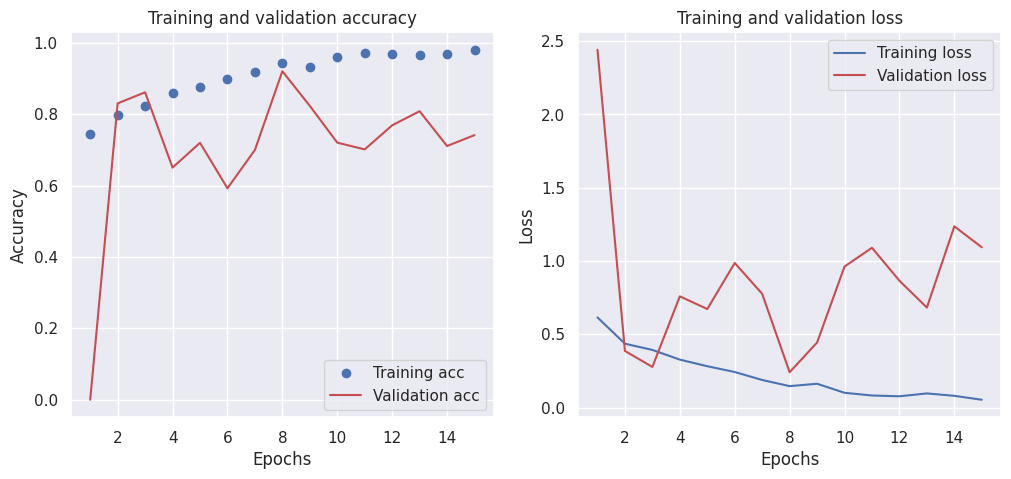

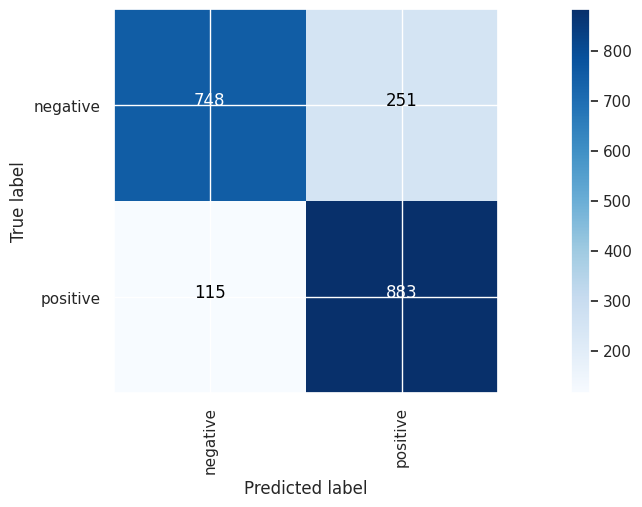

Final Accuracy
0.8167250876314471
Model: "Exp03ConvResidualConnections"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_18 (InputLayer)       [(None, 5000, 1)]            0         []                            
                                                                                                  
 conv1d_53 (Conv1D)          (None, 4997, 64)             320       ['input_18[0][0]']            
                                                                                                  
 batch_normalization_24 (Ba  (None, 4997, 64)             256       ['conv1d_53[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 conv1d_54 (Conv1D)          (None, 4

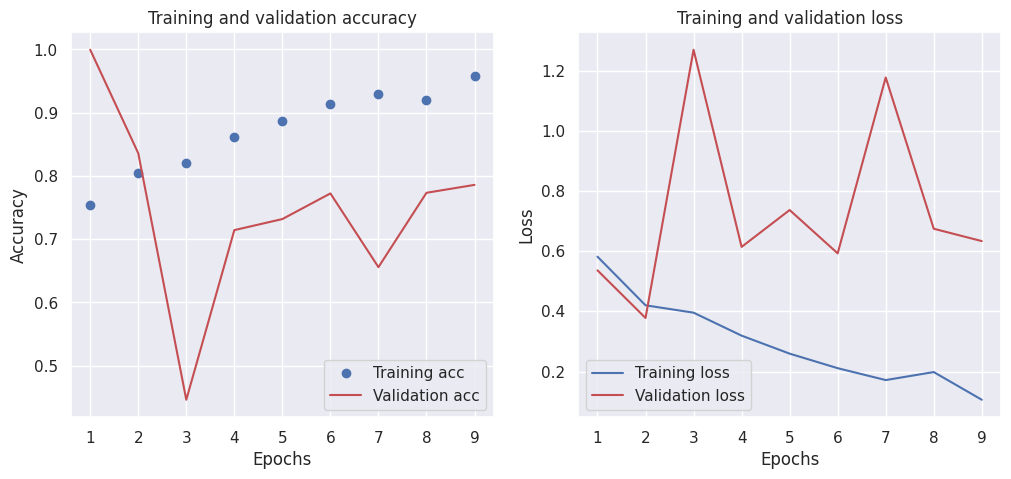

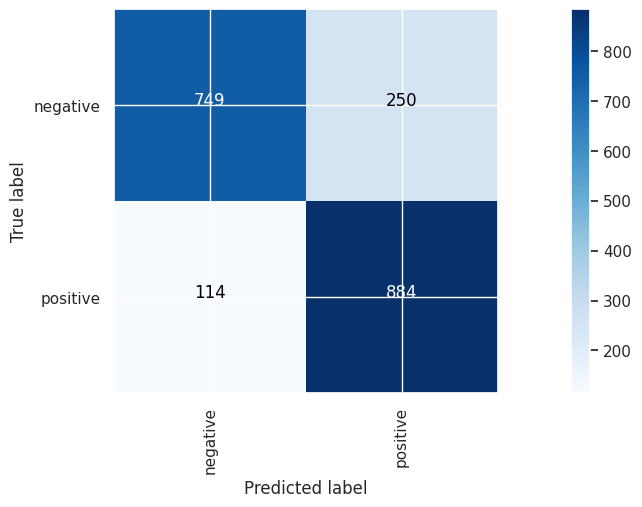

Final Accuracy
0.8177265898848273
Model: "Exp03ConvResidualConnections"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_19 (InputLayer)       [(None, 5000, 1)]            0         []                            
                                                                                                  
 conv1d_63 (Conv1D)          (None, 4997, 64)             320       ['input_19[0][0]']            
                                                                                                  
 batch_normalization_30 (Ba  (None, 4997, 64)             256       ['conv1d_63[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 conv1d_64 (Conv1D)          (None, 4

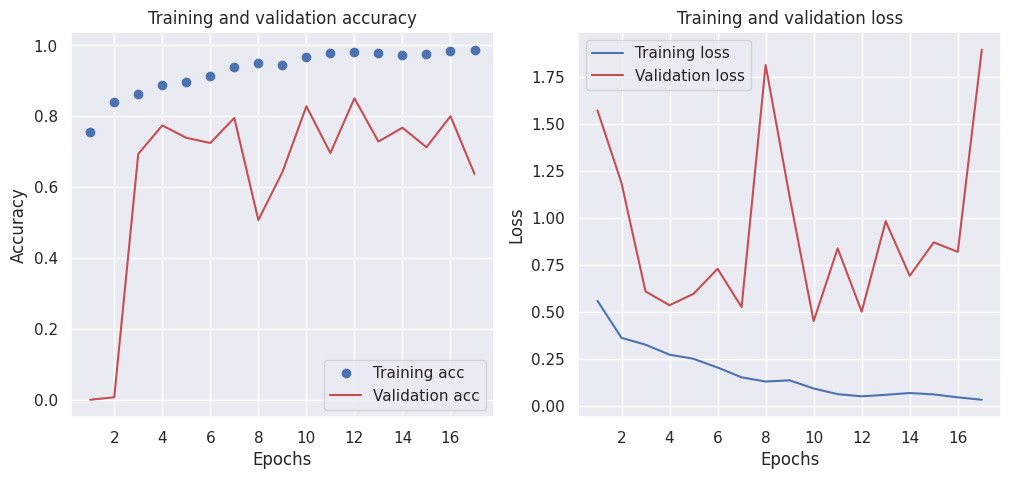

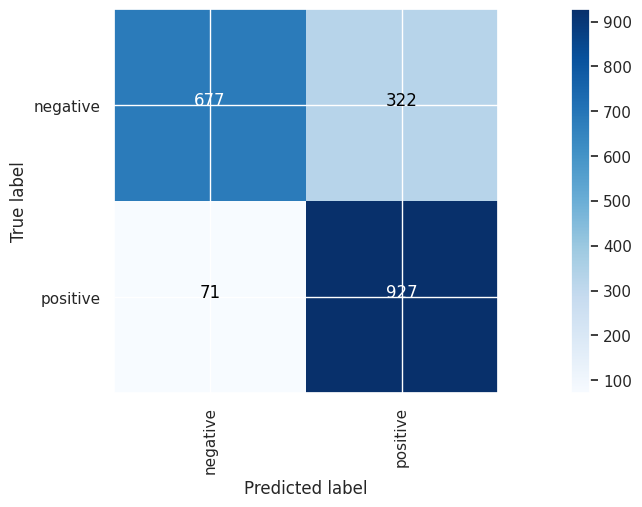

Final Accuracy
0.8032048072108162
Model: "Exp03ConvResidualConnections"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_20 (InputLayer)       [(None, 5000, 1)]            0         []                            
                                                                                                  
 conv1d_73 (Conv1D)          (None, 4997, 64)             320       ['input_20[0][0]']            
                                                                                                  
 batch_normalization_36 (Ba  (None, 4997, 64)             256       ['conv1d_73[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 conv1d_74 (Conv1D)          (None, 4

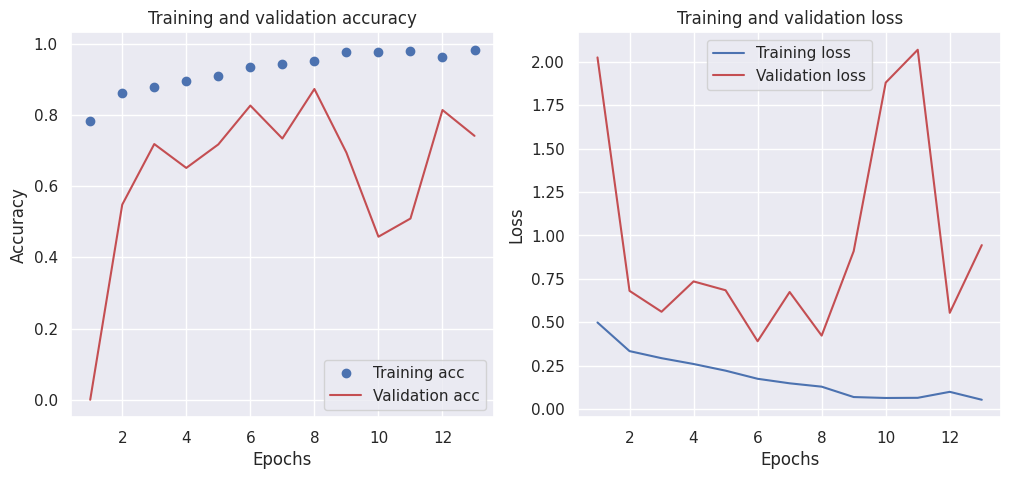

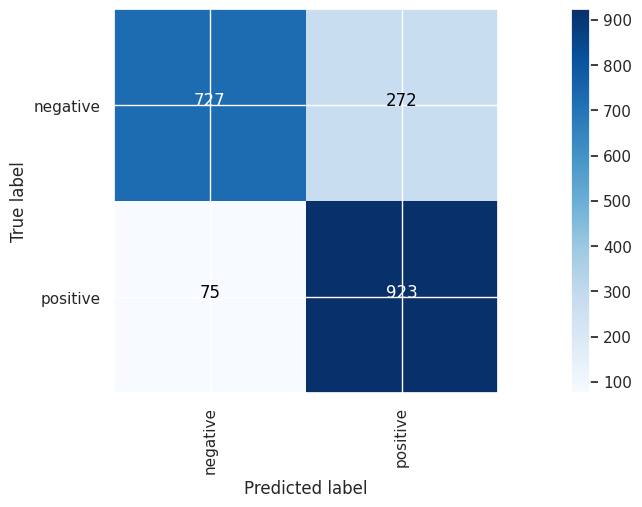

Final Accuracy
0.8262393590385578
Model: "Exp03ConvResidualConnections"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_21 (InputLayer)       [(None, 600)]                0         []                            
                                                                                                  
 embedding_6 (Embedding)     (None, 600, 50)              1488650   ['input_21[0][0]']            
                                                                                                  
 conv1d_83 (Conv1D)          (None, 597, 64)              12864     ['embedding_6[0][0]']         
                                                                                                  
 batch_normalization_42 (Ba  (None, 597, 64)              256       ['conv1d_83[0][0]']           
 tchNormalization)                   

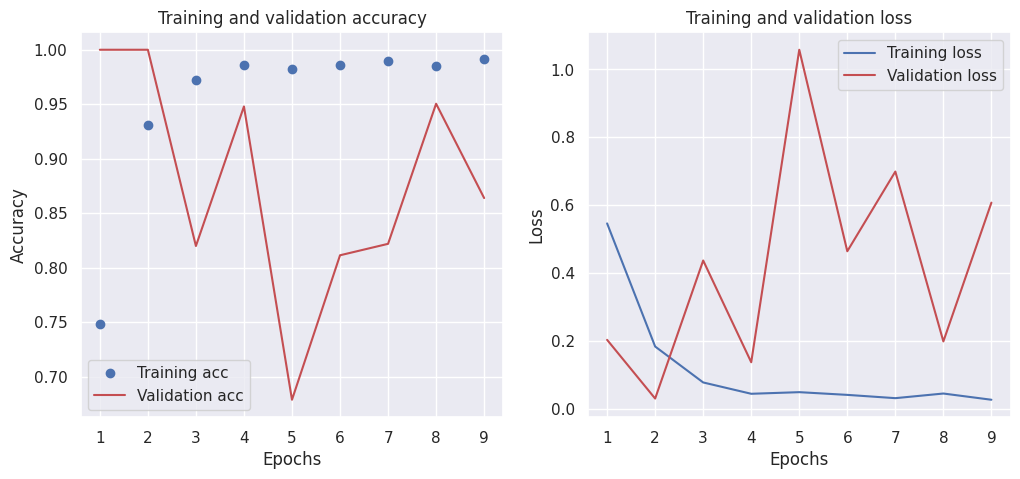

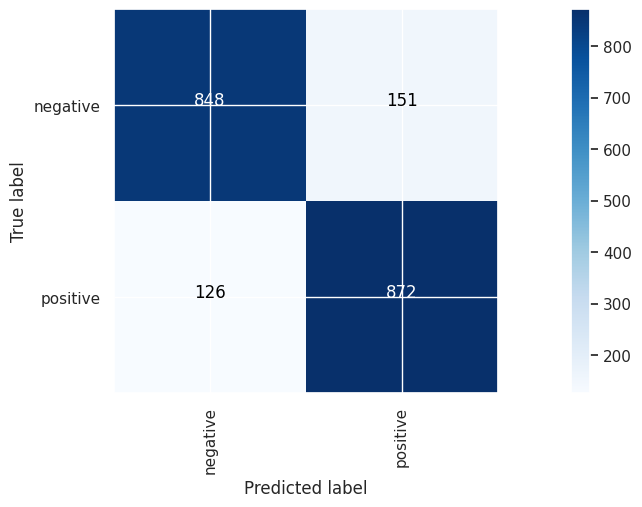

Final Accuracy
0.8612919379068603
Model: "Exp03ConvResidualConnections"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_22 (InputLayer)       [(None, 600)]                0         []                            
                                                                                                  
 embedding_7 (Embedding)     (None, 600, 50)              1488650   ['input_22[0][0]']            
                                                                                                  
 conv1d_93 (Conv1D)          (None, 597, 64)              12864     ['embedding_7[0][0]']         
                                                                                                  
 batch_normalization_48 (Ba  (None, 597, 64)              256       ['conv1d_93[0][0]']           
 tchNormalization)                   

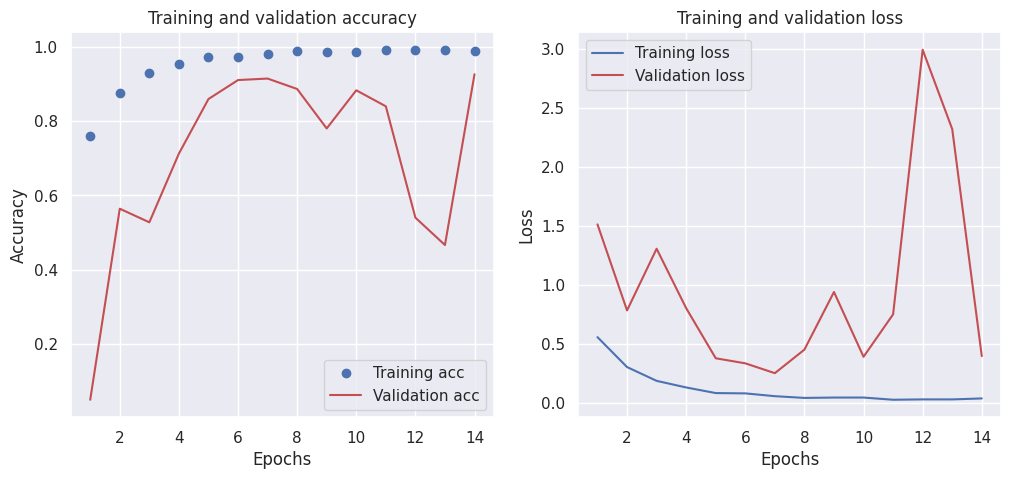

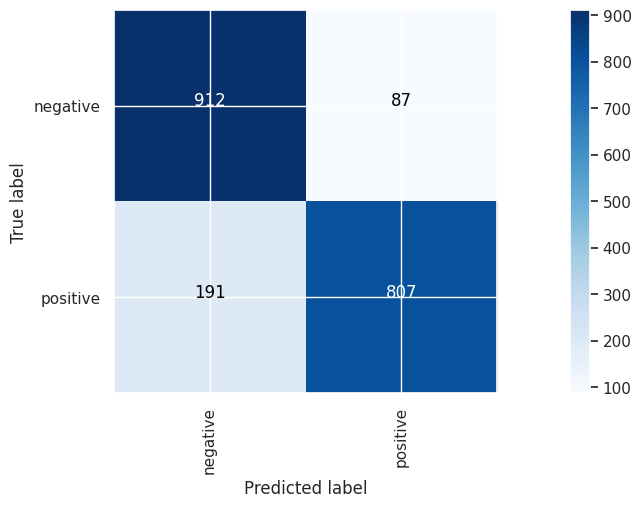

Final Accuracy
0.8607911867801703


In [33]:
# VSM models
results = []
name = "ConvResidualConnections"
description =   """
                number_of_filters=[64,128,256],
                kernel_size=4,
                dense_neurons=128,
                dropout=0.0, 
                pooling_size=4
                """
description = description.replace('\t', '').replace('\n', '').replace(' ', '')

number_of_filters=[64,128,256]
kernel_size=4
dense_neurons=128
dropout=0.0
pooling_size=4

# VSM models
results = []
for rep in vsm_model:
    build_exp03(name,
                description, 
                rep, 
                input_shape=(5000,1,),
                number_of_filters=number_of_filters,
                kernel_size=kernel_size,
                dense_neurons=dense_neurons,
                dropout=dropout, 
                pooling_size=pooling_size
                )

# Embedding with padding
embedding = layers.Embedding(input_dim=vocab_size,
                     output_dim=emb_dim,
                     trainable=True,
                     input_length=embedding_padding["train_text_features"].shape[1])
build_exp03(name,
            description, 
            embedding_padding, 
            input_shape=(embedding_padding["train_text_features"].shape[1],),
            embedding=embedding,
            number_of_filters=number_of_filters,
            kernel_size=kernel_size,
            dense_neurons=dense_neurons,
            dropout=dropout, 
            pooling_size=pooling_size        
            )

# GloVe
embedding = layers.Embedding(num_words,
                     emb_dim,
                     embeddings_initializer=Constant(embedding_glove["embedding_matrix"]),
                     trainable=True,
                     input_length=embedding_glove["train_text_features"].shape[1])

build_exp03(name,
            description, 
            embedding_glove, 
            input_shape=(embedding_glove["train_text_features"].shape[1],),
            embedding=embedding,
            number_of_filters=number_of_filters,
            kernel_size=kernel_size,
            dense_neurons=dense_neurons,
            dropout=dropout, 
            pooling_size=pooling_size        
            )
partial = pd.DataFrame(results)
partial.to_csv("exp_03_1.csv", index=False)

Model: "Exp03ConvResidualConnections"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_23 (InputLayer)       [(None, 5000, 1)]            0         []                            
                                                                                                  
 conv1d_103 (Conv1D)         (None, 4997, 64)             320       ['input_23[0][0]']            
                                                                                                  
 batch_normalization_54 (Ba  (None, 4997, 64)             256       ['conv1d_103[0][0]']          
 tchNormalization)                                                                                
                                                                                                  
 conv1d_104 (Conv1D)         (None, 4997, 64)             16448     ['b

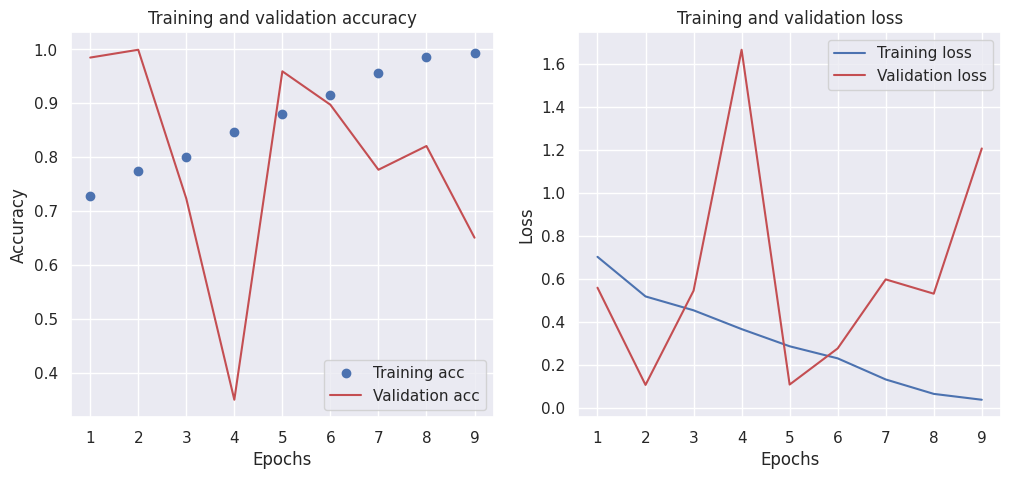

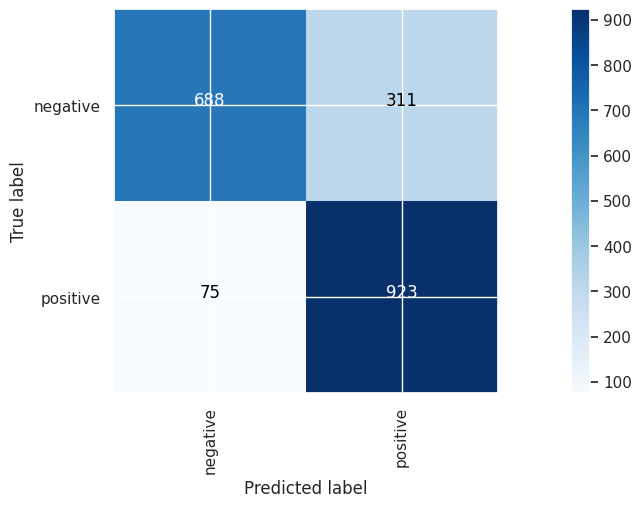

Final Accuracy
0.8067100650976464
Model: "Exp03ConvResidualConnections"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_24 (InputLayer)       [(None, 5000, 1)]            0         []                            
                                                                                                  
 conv1d_113 (Conv1D)         (None, 4997, 64)             320       ['input_24[0][0]']            
                                                                                                  
 batch_normalization_60 (Ba  (None, 4997, 64)             256       ['conv1d_113[0][0]']          
 tchNormalization)                                                                                
                                                                                                  
 conv1d_114 (Conv1D)         (None, 4

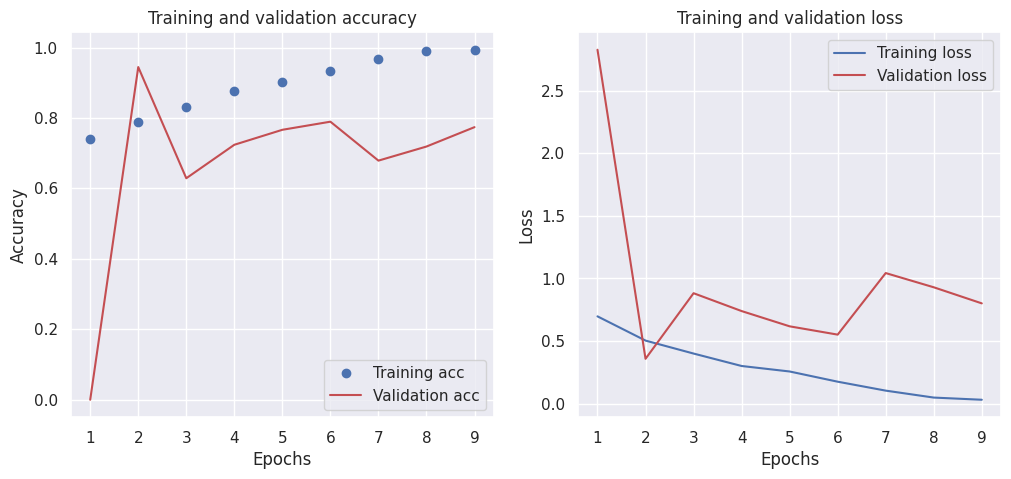

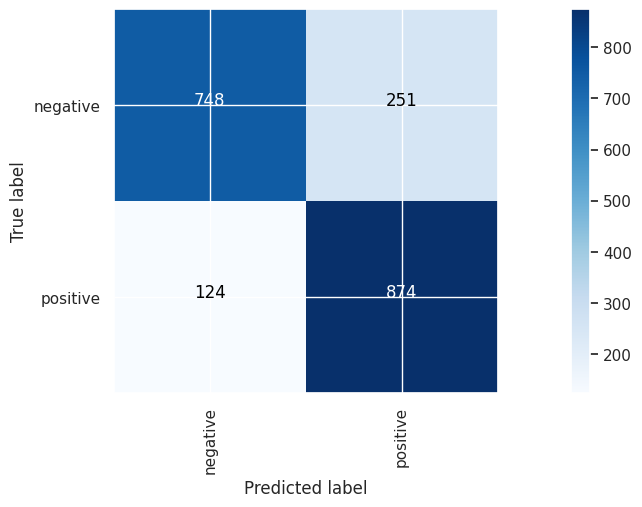

Final Accuracy
0.8122183274912369
Model: "Exp03ConvResidualConnections"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_25 (InputLayer)       [(None, 5000, 1)]            0         []                            
                                                                                                  
 conv1d_123 (Conv1D)         (None, 4997, 64)             320       ['input_25[0][0]']            
                                                                                                  
 batch_normalization_66 (Ba  (None, 4997, 64)             256       ['conv1d_123[0][0]']          
 tchNormalization)                                                                                
                                                                                                  
 conv1d_124 (Conv1D)         (None, 4

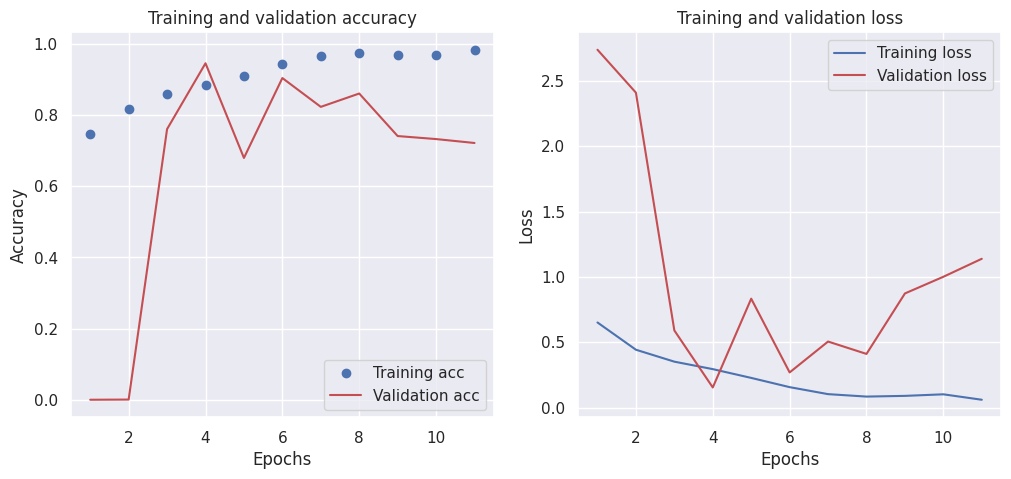

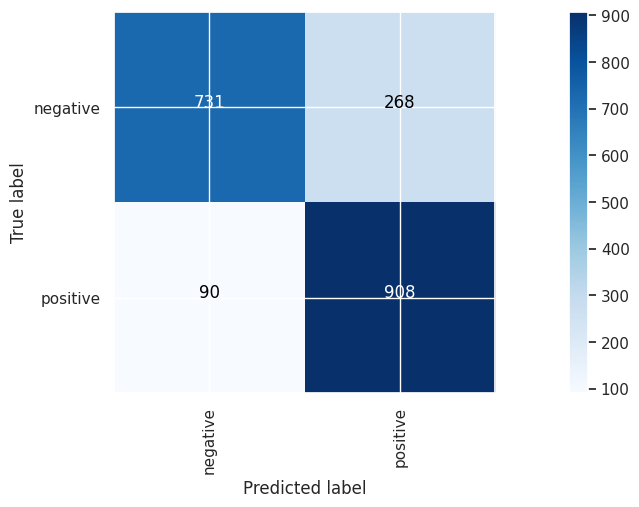

Final Accuracy
0.8207310966449675
Model: "Exp03ConvResidualConnections"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_26 (InputLayer)       [(None, 5000, 1)]            0         []                            
                                                                                                  
 conv1d_133 (Conv1D)         (None, 4997, 64)             320       ['input_26[0][0]']            
                                                                                                  
 batch_normalization_72 (Ba  (None, 4997, 64)             256       ['conv1d_133[0][0]']          
 tchNormalization)                                                                                
                                                                                                  
 conv1d_134 (Conv1D)         (None, 4

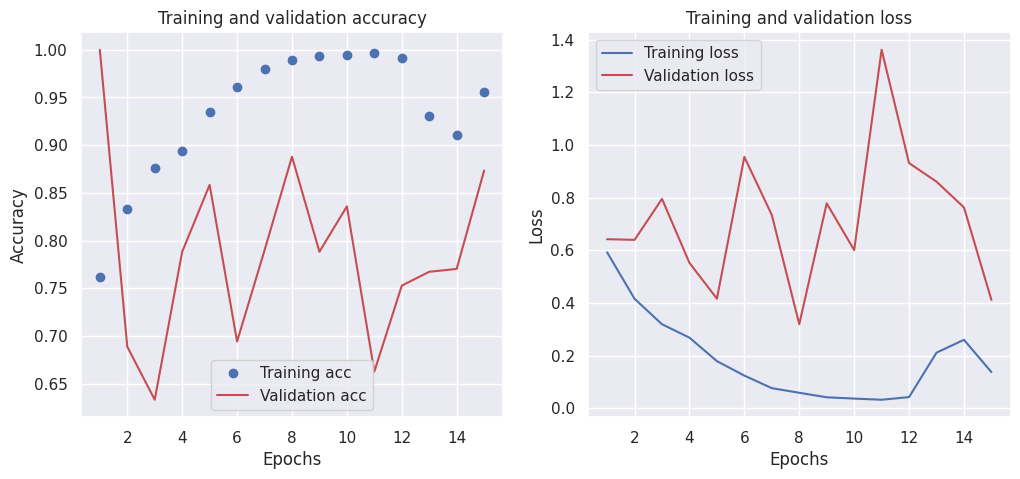

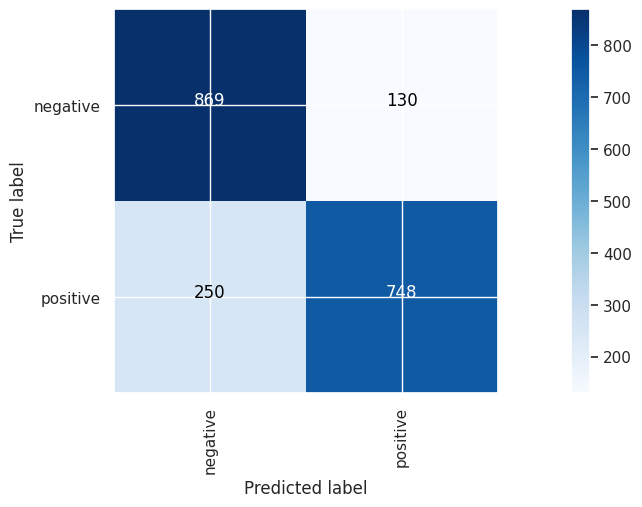

Final Accuracy
0.8097145718577867
Model: "Exp03ConvResidualConnections"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_27 (InputLayer)       [(None, 600)]                0         []                            
                                                                                                  
 embedding_8 (Embedding)     (None, 600, 50)              1488650   ['input_27[0][0]']            
                                                                                                  
 conv1d_143 (Conv1D)         (None, 597, 64)              12864     ['embedding_8[0][0]']         
                                                                                                  
 batch_normalization_78 (Ba  (None, 597, 64)              256       ['conv1d_143[0][0]']          
 tchNormalization)                   

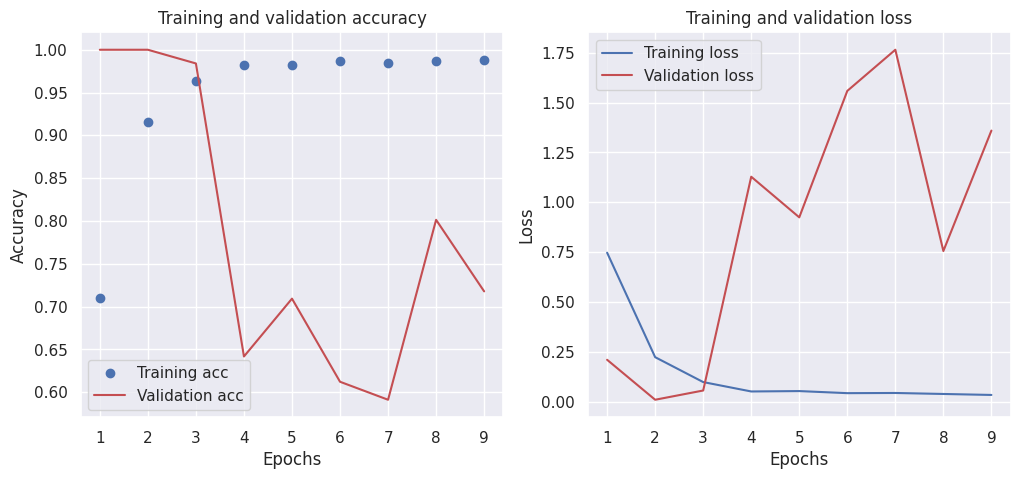

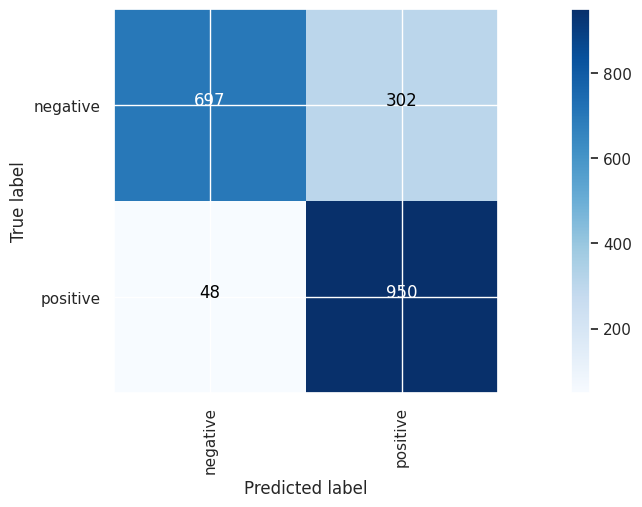

Final Accuracy
0.8247371056584877
Model: "Exp03ConvResidualConnections"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_28 (InputLayer)       [(None, 600)]                0         []                            
                                                                                                  
 embedding_9 (Embedding)     (None, 600, 50)              1488650   ['input_28[0][0]']            
                                                                                                  
 conv1d_153 (Conv1D)         (None, 597, 64)              12864     ['embedding_9[0][0]']         
                                                                                                  
 batch_normalization_84 (Ba  (None, 597, 64)              256       ['conv1d_153[0][0]']          
 tchNormalization)                   

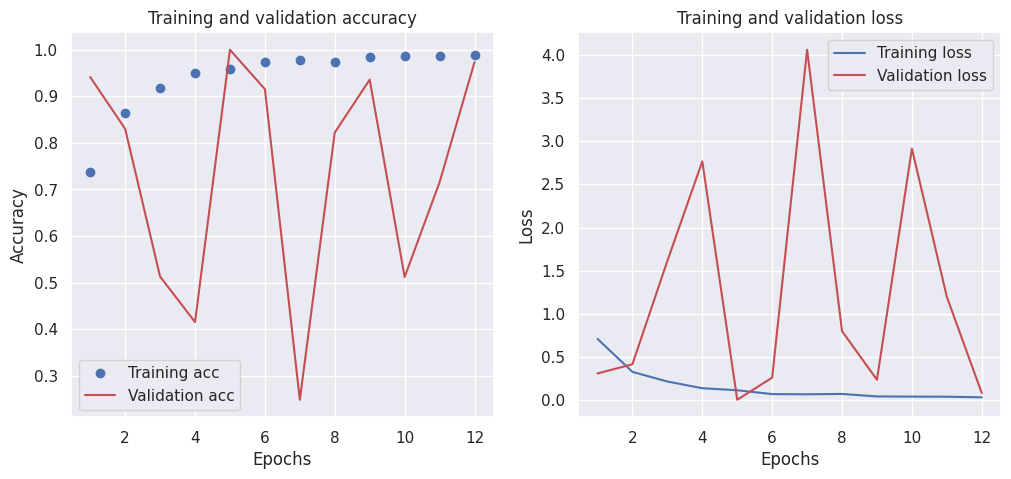

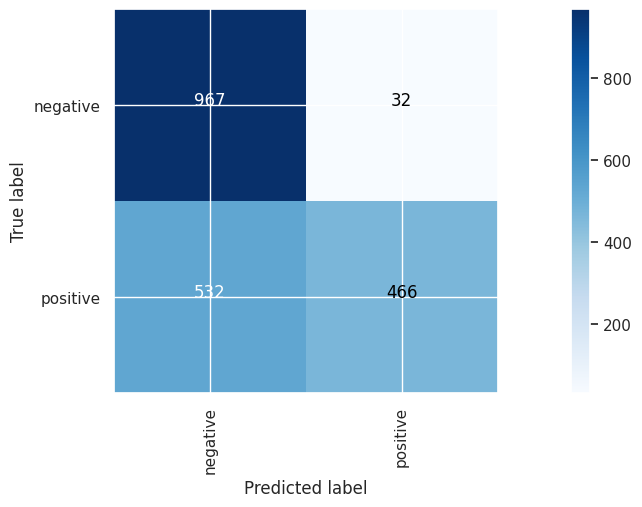

Final Accuracy
0.7175763645468203


In [35]:
# VSM models
results = []
name = "ConvResidualConnections"
description =   """
                number_of_filters=[64,128,256],
                kernel_size=4,
                dense_neurons=0,
                dropout=0.0,
                pooling_size=4
                """
description = description.replace('\t', '').replace('\n', '').replace(' ', '')

number_of_filters=[64,128,256]
kernel_size=4
dense_neurons=0
dropout=0.0
pooling_size=4

# VSM models
results = []
for rep in vsm_model:
    build_exp03(name,
                description, 
                rep, 
                input_shape=(5000,1,),
                number_of_filters=number_of_filters,
                kernel_size=kernel_size,
                dense_neurons=dense_neurons,
                dropout=dropout, 
                pooling_size=pooling_size
                )

# Embedding with padding
embedding = layers.Embedding(input_dim=vocab_size,
                     output_dim=emb_dim,
                     trainable=True,
                     input_length=embedding_padding["train_text_features"].shape[1])
build_exp03(name,
            description, 
            embedding_padding, 
            input_shape=(embedding_padding["train_text_features"].shape[1],),
            embedding=embedding,
            number_of_filters=number_of_filters,
            kernel_size=kernel_size,
            dense_neurons=dense_neurons,
            dropout=dropout, 
            pooling_size=pooling_size        
            )

# GloVe
embedding = layers.Embedding(num_words,
                     emb_dim,
                     embeddings_initializer=Constant(embedding_glove["embedding_matrix"]),
                     trainable=True,
                     input_length=embedding_glove["train_text_features"].shape[1])

build_exp03(name,
            description, 
            embedding_glove, 
            input_shape=(embedding_glove["train_text_features"].shape[1],),
            embedding=embedding,
            number_of_filters=number_of_filters,
            kernel_size=kernel_size,
            dense_neurons=dense_neurons,
            dropout=dropout, 
            pooling_size=pooling_size        
            )
partial = pd.DataFrame(results)
partial.to_csv("exp_03_2.csv", index=False)

Model: "Exp03ConvResidualConnections"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_29 (InputLayer)       [(None, 5000, 1)]            0         []                            
                                                                                                  
 conv1d_163 (Conv1D)         (None, 4997, 64)             320       ['input_29[0][0]']            
                                                                                                  
 batch_normalization_90 (Ba  (None, 4997, 64)             256       ['conv1d_163[0][0]']          
 tchNormalization)                                                                                
                                                                                                  
 conv1d_164 (Conv1D)         (None, 4997, 64)             16448     ['b

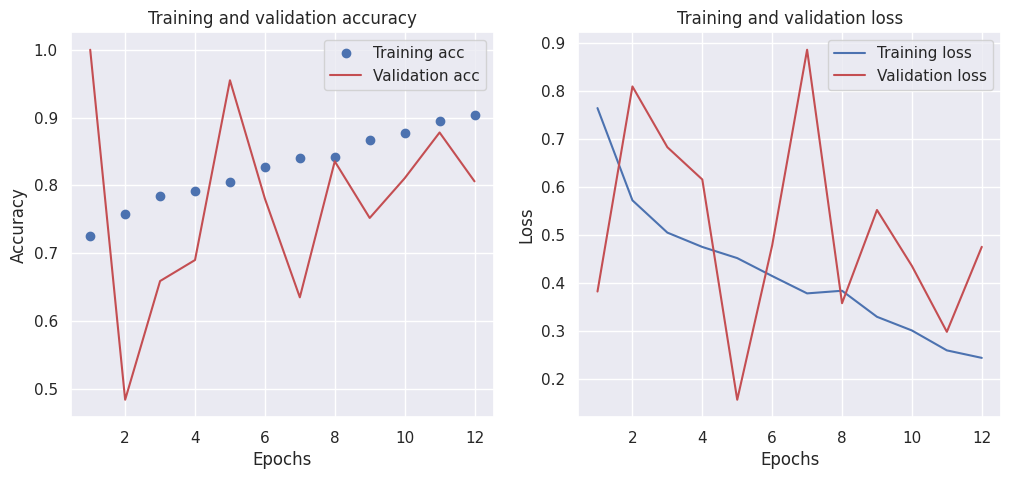

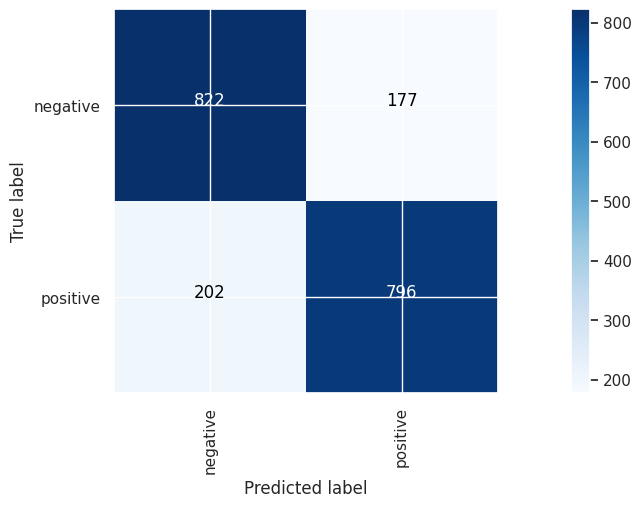

Final Accuracy
0.8102153229844767
Model: "Exp03ConvResidualConnections"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_30 (InputLayer)       [(None, 5000, 1)]            0         []                            
                                                                                                  
 conv1d_173 (Conv1D)         (None, 4997, 64)             320       ['input_30[0][0]']            
                                                                                                  
 batch_normalization_96 (Ba  (None, 4997, 64)             256       ['conv1d_173[0][0]']          
 tchNormalization)                                                                                
                                                                                                  
 conv1d_174 (Conv1D)         (None, 4

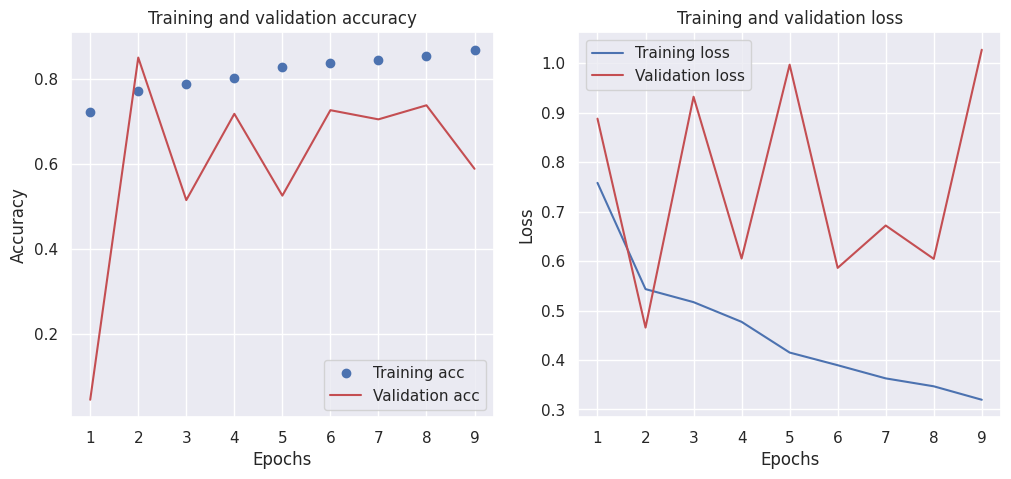

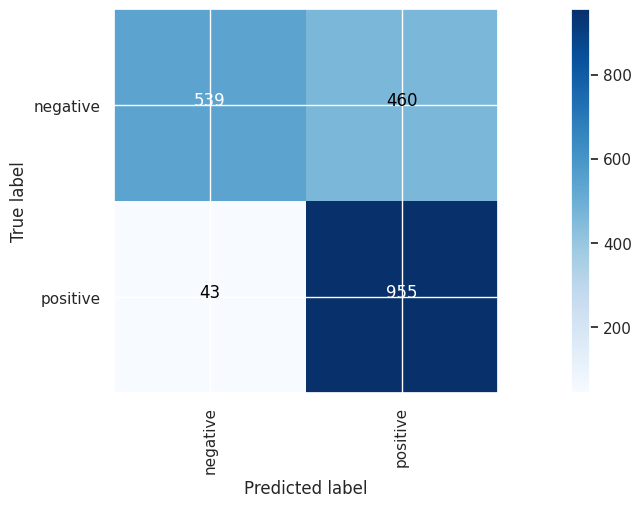

Final Accuracy
0.7481221832749124
Model: "Exp03ConvResidualConnections"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_31 (InputLayer)       [(None, 5000, 1)]            0         []                            
                                                                                                  
 conv1d_183 (Conv1D)         (None, 4997, 64)             320       ['input_31[0][0]']            
                                                                                                  
 batch_normalization_102 (B  (None, 4997, 64)             256       ['conv1d_183[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 conv1d_184 (Conv1D)         (None, 4

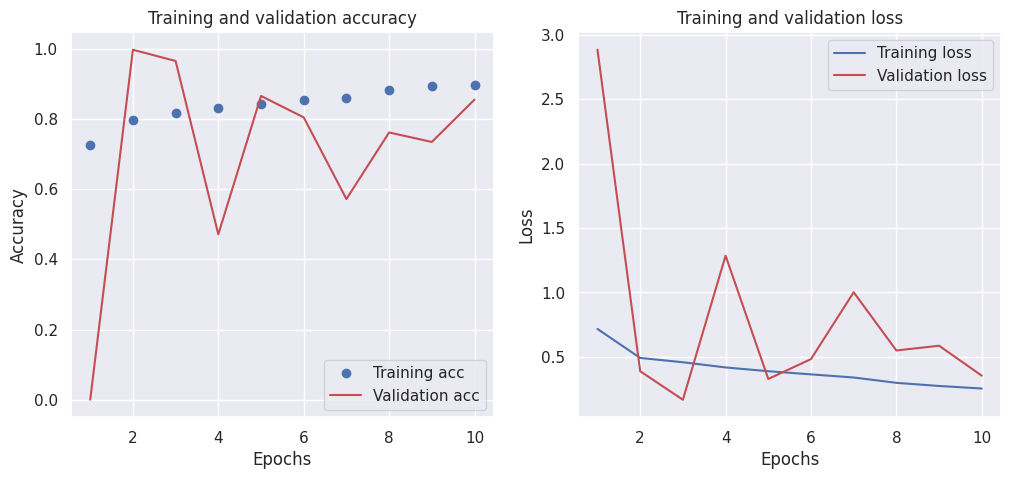

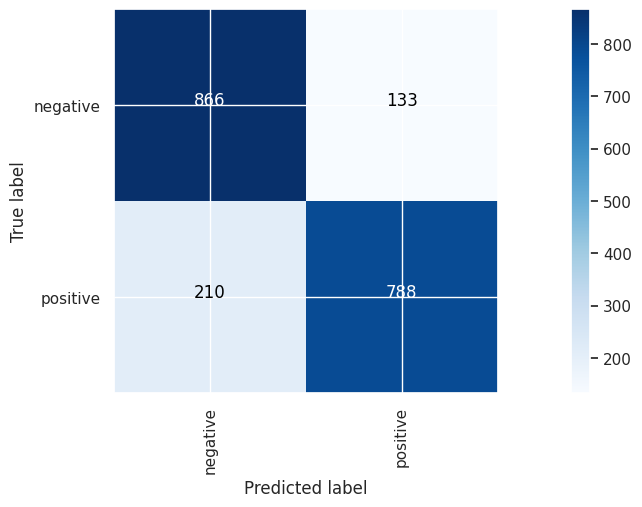

Final Accuracy
0.828242363545318
Model: "Exp03ConvResidualConnections"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_32 (InputLayer)       [(None, 5000, 1)]            0         []                            
                                                                                                  
 conv1d_193 (Conv1D)         (None, 4997, 64)             320       ['input_32[0][0]']            
                                                                                                  
 batch_normalization_108 (B  (None, 4997, 64)             256       ['conv1d_193[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 conv1d_194 (Conv1D)         (None, 49

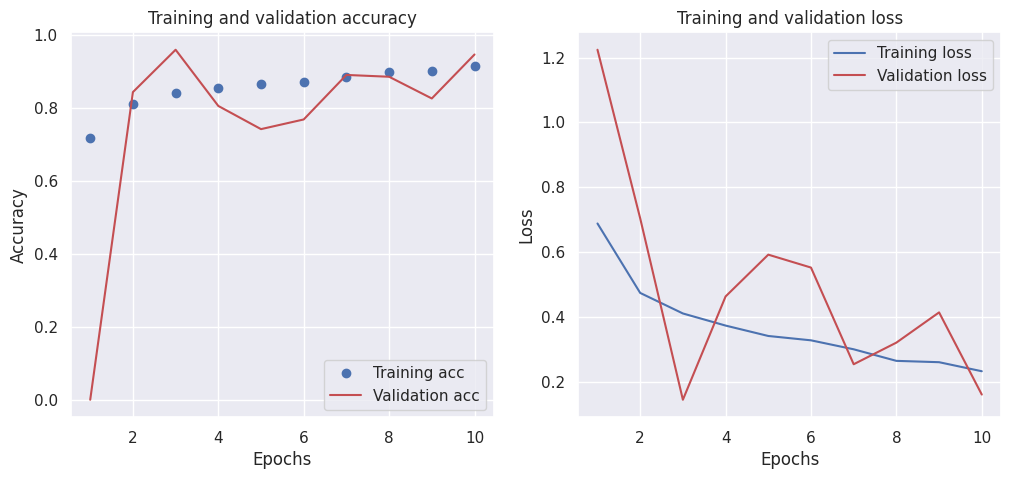

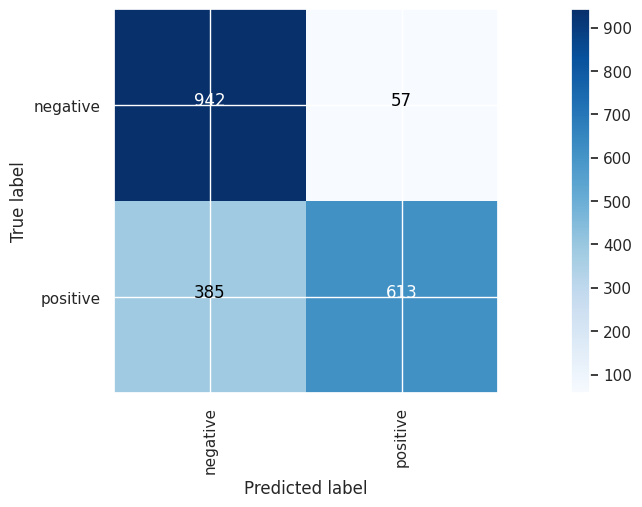

Final Accuracy
0.7786680020030045
Model: "Exp03ConvResidualConnections"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_33 (InputLayer)       [(None, 600)]                0         []                            
                                                                                                  
 embedding_10 (Embedding)    (None, 600, 50)              1488650   ['input_33[0][0]']            
                                                                                                  
 conv1d_203 (Conv1D)         (None, 597, 64)              12864     ['embedding_10[0][0]']        
                                                                                                  
 batch_normalization_114 (B  (None, 597, 64)              256       ['conv1d_203[0][0]']          
 atchNormalization)                  

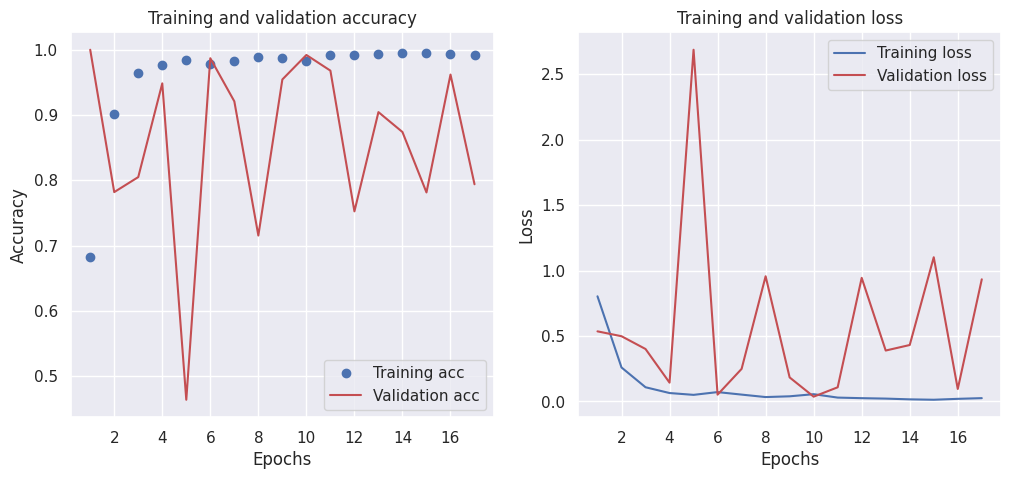

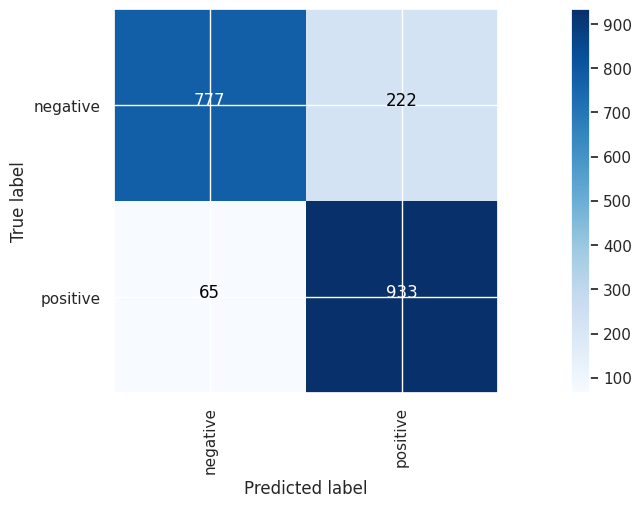

Final Accuracy
0.85628442663996
Model: "Exp03ConvResidualConnections"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_34 (InputLayer)       [(None, 600)]                0         []                            
                                                                                                  
 embedding_11 (Embedding)    (None, 600, 50)              1488650   ['input_34[0][0]']            
                                                                                                  
 conv1d_213 (Conv1D)         (None, 597, 64)              12864     ['embedding_11[0][0]']        
                                                                                                  
 batch_normalization_120 (B  (None, 597, 64)              256       ['conv1d_213[0][0]']          
 atchNormalization)                    

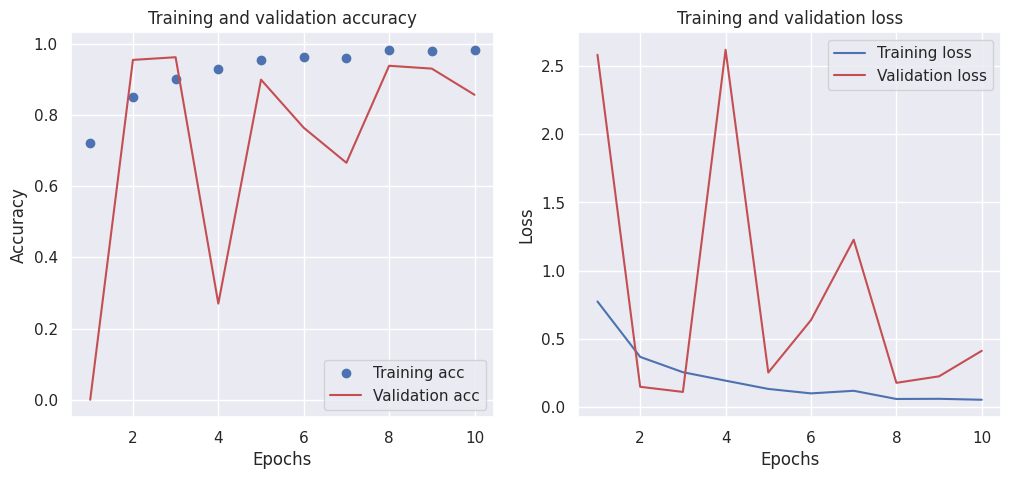

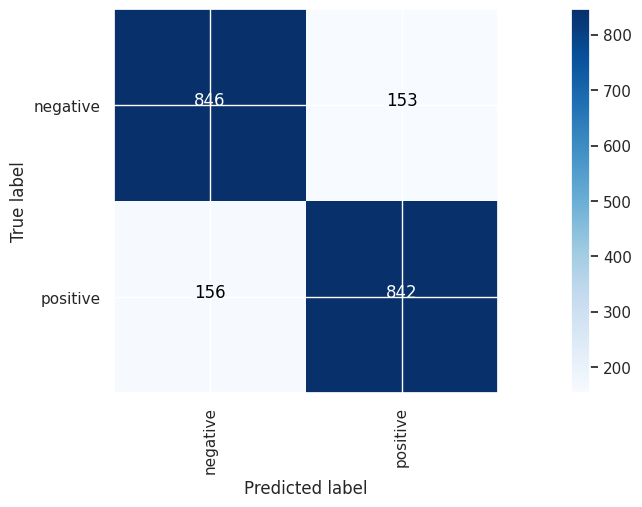

Final Accuracy
0.8452679018527791


In [36]:
# VSM models
results = []
name = "ConvResidualConnections"
description =   """
                number_of_filters=[64,128,256],
                kernel_size=4,
                dense_neurons=0,
                dropout=0.15,
                pooling_size=4
                """
description = description.replace('\t', '').replace('\n', '').replace(' ', '')

number_of_filters=[64,128,256]
kernel_size=4
dense_neurons=0
dropout=0.15
pooling_size=4

# VSM models
results = []
for rep in vsm_model:
    build_exp03(name,
                description, 
                rep, 
                input_shape=(5000,1,),
                number_of_filters=number_of_filters,
                kernel_size=kernel_size,
                dense_neurons=dense_neurons,
                dropout=dropout, 
                pooling_size=pooling_size
                )

# Embedding with padding
embedding = layers.Embedding(input_dim=vocab_size,
                     output_dim=emb_dim,
                     trainable=True,
                     input_length=embedding_padding["train_text_features"].shape[1])
build_exp03(name,
            description, 
            embedding_padding, 
            input_shape=(embedding_padding["train_text_features"].shape[1],),
            embedding=embedding,
            number_of_filters=number_of_filters,
            kernel_size=kernel_size,
            dense_neurons=dense_neurons,
            dropout=dropout, 
            pooling_size=pooling_size        
            )

# GloVe
embedding = layers.Embedding(num_words,
                     emb_dim,
                     embeddings_initializer=Constant(embedding_glove["embedding_matrix"]),
                     trainable=True,
                     input_length=embedding_glove["train_text_features"].shape[1])

build_exp03(name,
            description, 
            embedding_glove, 
            input_shape=(embedding_glove["train_text_features"].shape[1],),
            embedding=embedding,
            number_of_filters=number_of_filters,
            kernel_size=kernel_size,
            dense_neurons=dense_neurons,
            dropout=dropout, 
            pooling_size=pooling_size        
            )
partial = pd.DataFrame(results)
partial.to_csv("exp_03_3.csv", index=False)

Model: "Exp03ConvResidualConnections"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_35 (InputLayer)       [(None, 5000, 1)]            0         []                            
                                                                                                  
 conv1d_223 (Conv1D)         (None, 4997, 64)             320       ['input_35[0][0]']            
                                                                                                  
 batch_normalization_126 (B  (None, 4997, 64)             256       ['conv1d_223[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 conv1d_224 (Conv1D)         (None, 4997, 64)             16448     ['b

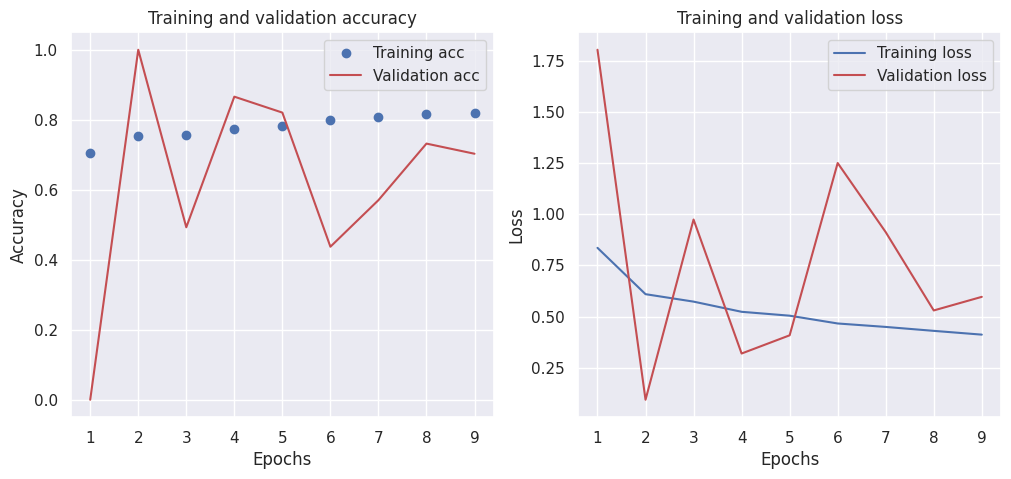

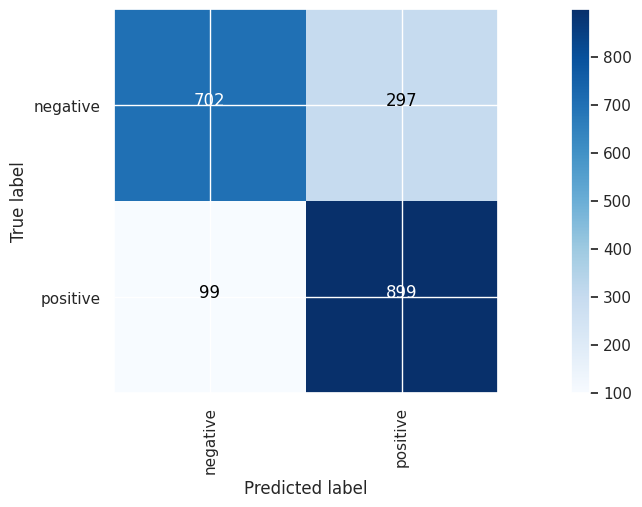

Final Accuracy
0.8017025538307461
Model: "Exp03ConvResidualConnections"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_36 (InputLayer)       [(None, 5000, 1)]            0         []                            
                                                                                                  
 conv1d_233 (Conv1D)         (None, 4997, 64)             320       ['input_36[0][0]']            
                                                                                                  
 batch_normalization_132 (B  (None, 4997, 64)             256       ['conv1d_233[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 conv1d_234 (Conv1D)         (None, 4

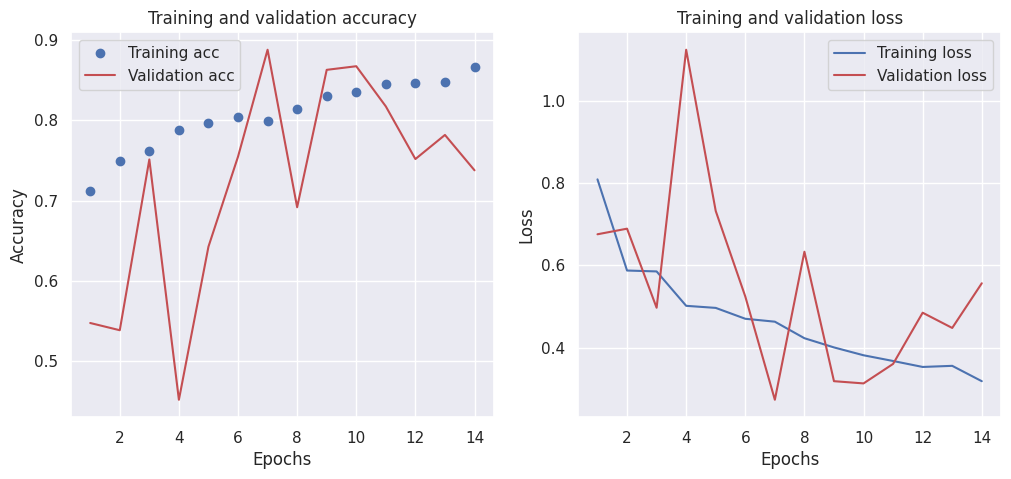

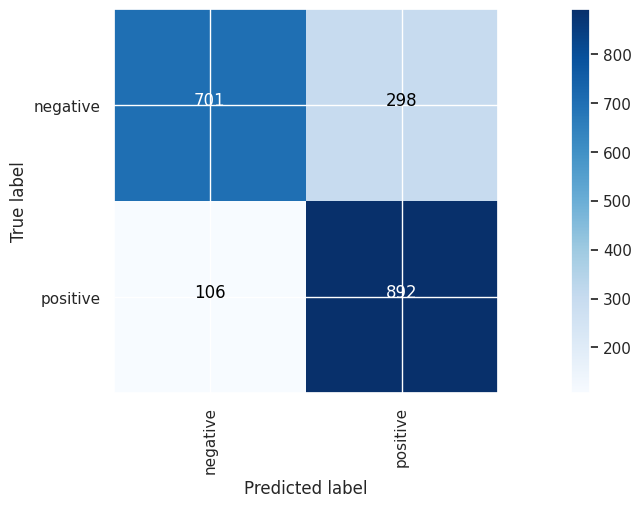

Final Accuracy
0.7976965448172258
Model: "Exp03ConvResidualConnections"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_37 (InputLayer)       [(None, 5000, 1)]            0         []                            
                                                                                                  
 conv1d_243 (Conv1D)         (None, 4997, 64)             320       ['input_37[0][0]']            
                                                                                                  
 batch_normalization_138 (B  (None, 4997, 64)             256       ['conv1d_243[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 conv1d_244 (Conv1D)         (None, 4

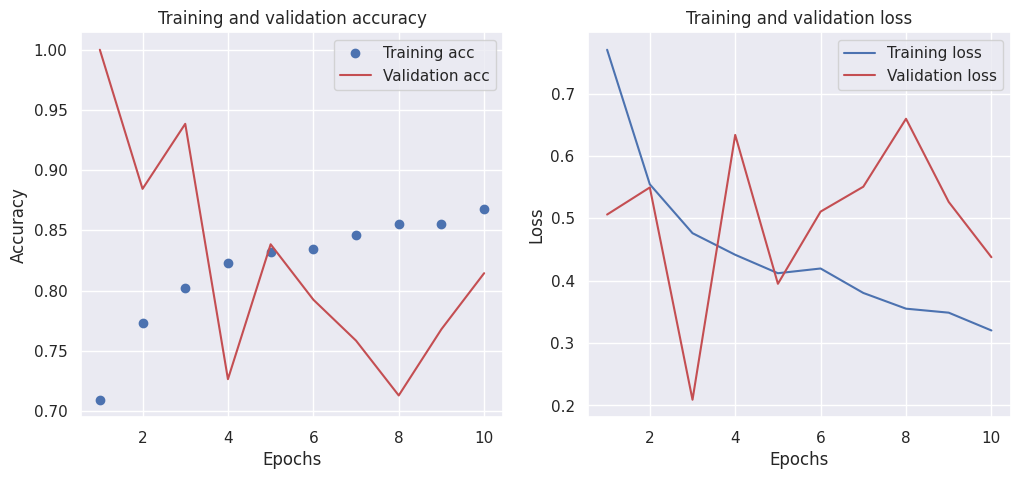

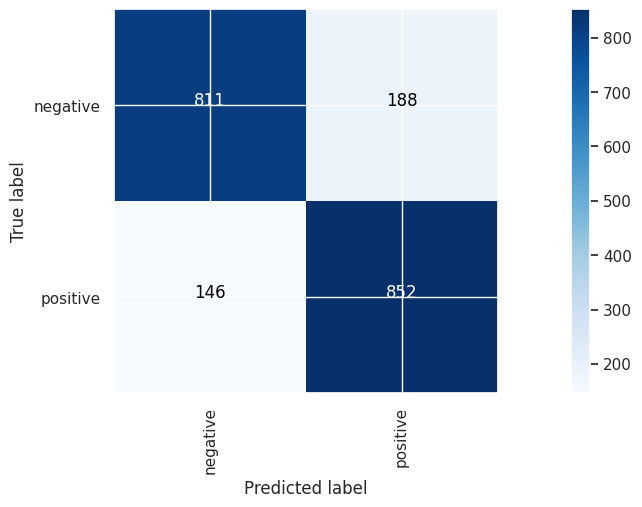

Final Accuracy
0.8327491236855283
Model: "Exp03ConvResidualConnections"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_38 (InputLayer)       [(None, 5000, 1)]            0         []                            
                                                                                                  
 conv1d_253 (Conv1D)         (None, 4997, 64)             320       ['input_38[0][0]']            
                                                                                                  
 batch_normalization_144 (B  (None, 4997, 64)             256       ['conv1d_253[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 conv1d_254 (Conv1D)         (None, 4

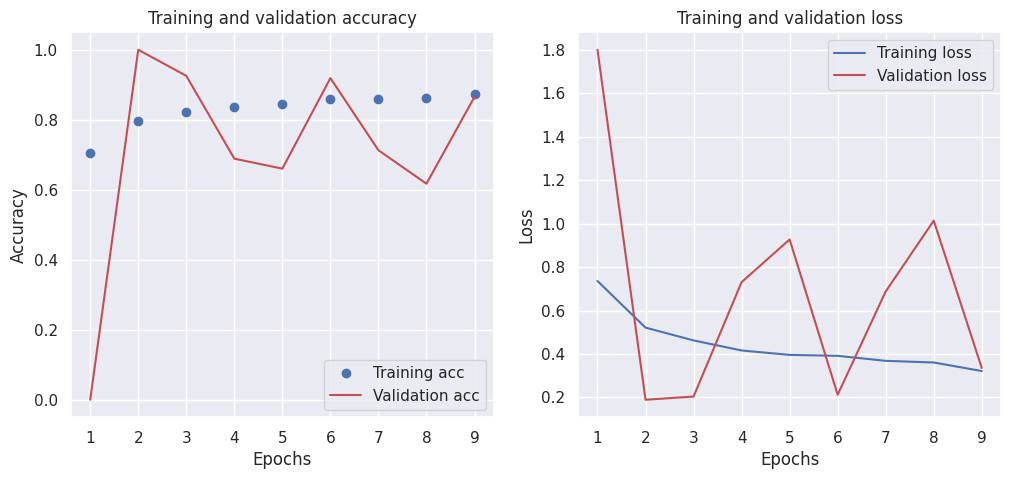

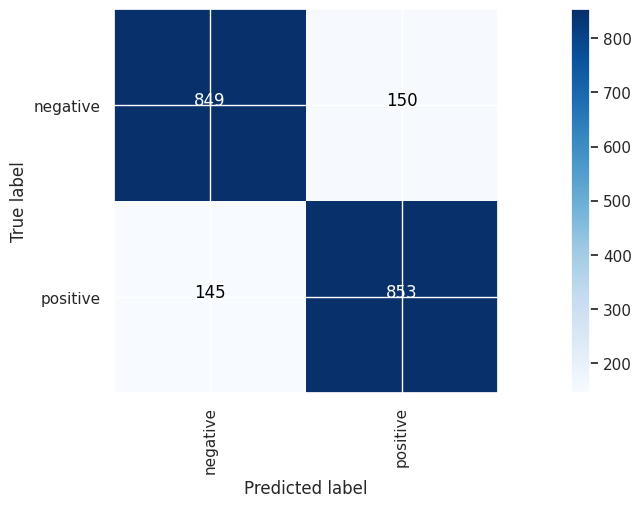

Final Accuracy
0.8522784176264396
Model: "Exp03ConvResidualConnections"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_39 (InputLayer)       [(None, 600)]                0         []                            
                                                                                                  
 embedding_12 (Embedding)    (None, 600, 50)              1488650   ['input_39[0][0]']            
                                                                                                  
 conv1d_263 (Conv1D)         (None, 597, 64)              12864     ['embedding_12[0][0]']        
                                                                                                  
 batch_normalization_150 (B  (None, 597, 64)              256       ['conv1d_263[0][0]']          
 atchNormalization)                  

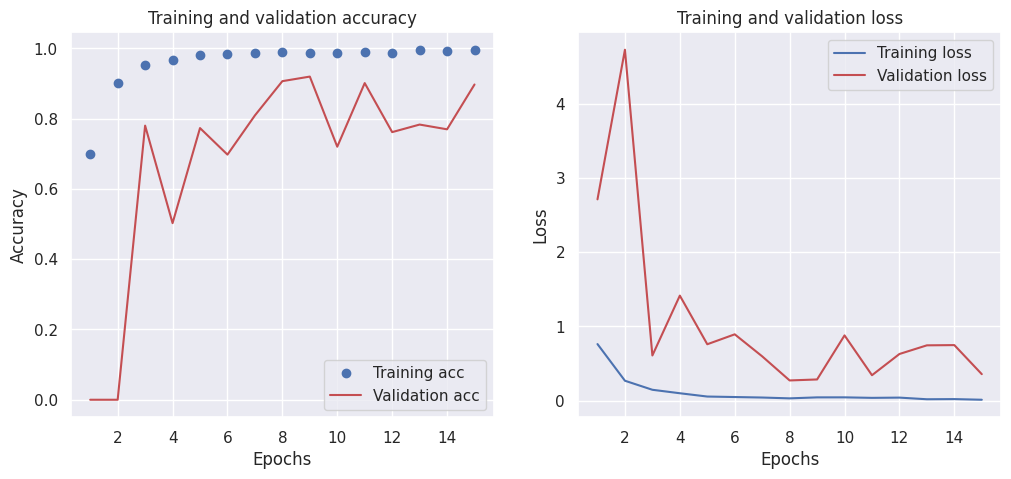

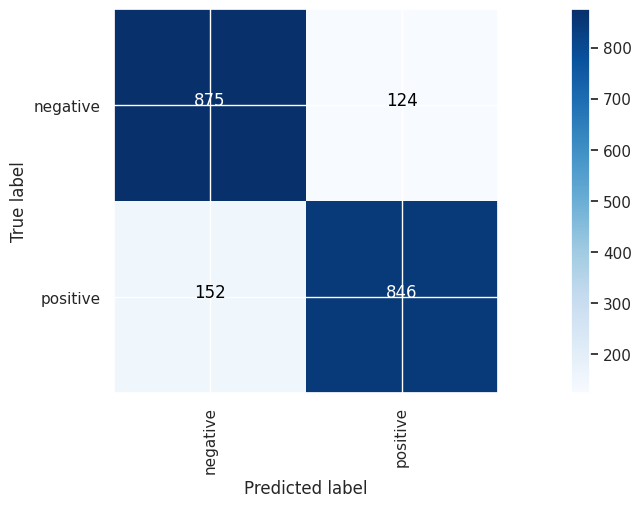

Final Accuracy
0.8617926890335503
Model: "Exp03ConvResidualConnections"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_40 (InputLayer)       [(None, 600)]                0         []                            
                                                                                                  
 embedding_13 (Embedding)    (None, 600, 50)              1488650   ['input_40[0][0]']            
                                                                                                  
 conv1d_273 (Conv1D)         (None, 597, 64)              12864     ['embedding_13[0][0]']        
                                                                                                  
 batch_normalization_156 (B  (None, 597, 64)              256       ['conv1d_273[0][0]']          
 atchNormalization)                  

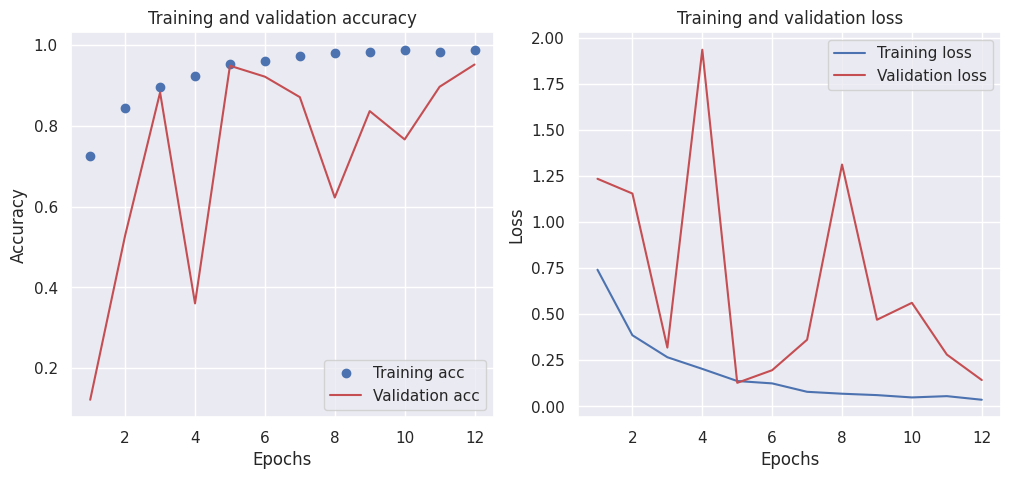

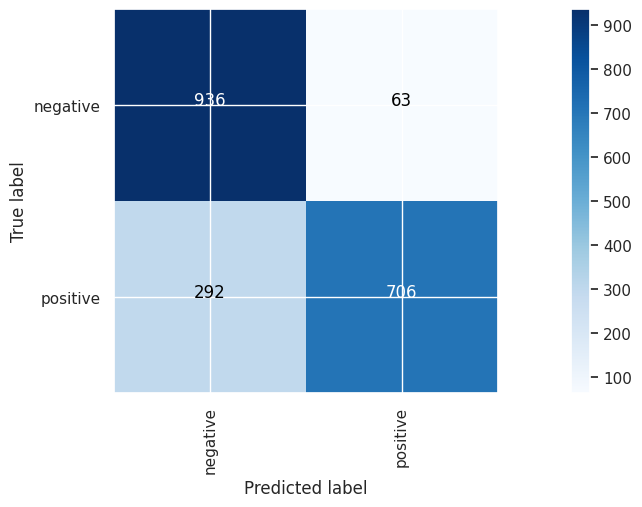

Final Accuracy
0.8222333500250375


In [37]:
# VSM models
results = []
name = "ConvResidualConnections"
description =   """
                number_of_filters=[64,128,256],
                kernel_size=4,
                dense_neurons=0,
                dropout=0.25,
                pooling_size=4
                """
description = description.replace('\t', '').replace('\n', '').replace(' ', '')

number_of_filters=[64,128,256]
kernel_size=4
dense_neurons=0
dropout=0.25
pooling_size=4

# VSM models
results = []
for rep in vsm_model:
    build_exp03(name,
                description, 
                rep, 
                input_shape=(5000,1,),
                number_of_filters=number_of_filters,
                kernel_size=kernel_size,
                dense_neurons=dense_neurons,
                dropout=dropout, 
                pooling_size=pooling_size
                )

# Embedding with padding
embedding = layers.Embedding(input_dim=vocab_size,
                     output_dim=emb_dim,
                     trainable=True,
                     input_length=embedding_padding["train_text_features"].shape[1])
build_exp03(name,
            description, 
            embedding_padding, 
            input_shape=(embedding_padding["train_text_features"].shape[1],),
            embedding=embedding,
            number_of_filters=number_of_filters,
            kernel_size=kernel_size,
            dense_neurons=dense_neurons,
            dropout=dropout, 
            pooling_size=pooling_size        
            )

# GloVe
embedding = layers.Embedding(num_words,
                     emb_dim,
                     embeddings_initializer=Constant(embedding_glove["embedding_matrix"]),
                     trainable=True,
                     input_length=embedding_glove["train_text_features"].shape[1])

build_exp03(name,
            description, 
            embedding_glove, 
            input_shape=(embedding_glove["train_text_features"].shape[1],),
            embedding=embedding,
            number_of_filters=number_of_filters,
            kernel_size=kernel_size,
            dense_neurons=dense_neurons,
            dropout=dropout, 
            pooling_size=pooling_size        
            )
partial = pd.DataFrame(results)
partial.to_csv("exp_03_4.csv", index=False)

Model: "Exp03ConvResidualConnections"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_41 (InputLayer)       [(None, 5000, 1)]            0         []                            
                                                                                                  
 conv1d_283 (Conv1D)         (None, 4997, 32)             160       ['input_41[0][0]']            
                                                                                                  
 batch_normalization_162 (B  (None, 4997, 32)             128       ['conv1d_283[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 conv1d_284 (Conv1D)         (None, 4997, 32)             4128      ['b

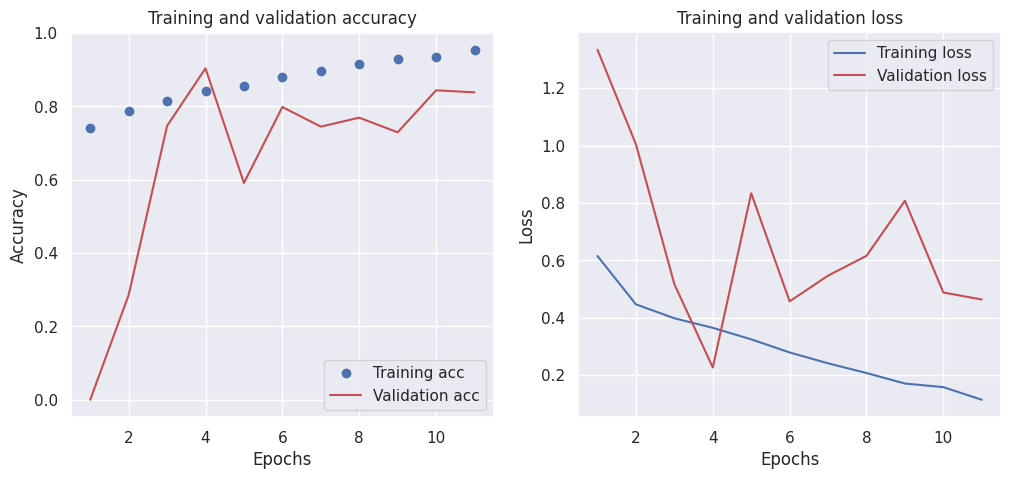

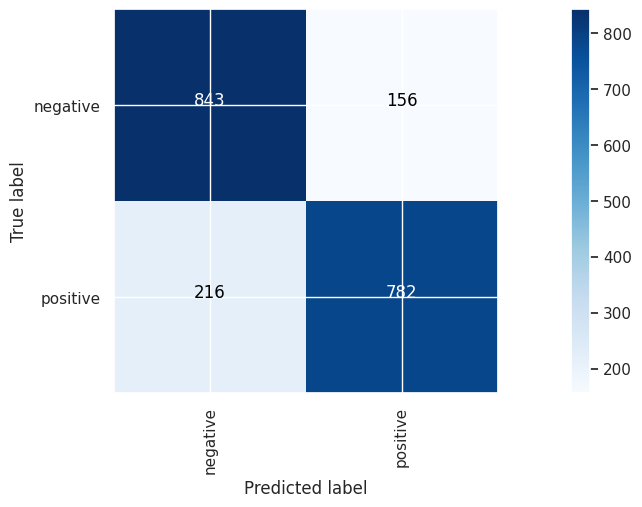

Final Accuracy
0.8137205808713069
Model: "Exp03ConvResidualConnections"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_42 (InputLayer)       [(None, 5000, 1)]            0         []                            
                                                                                                  
 conv1d_293 (Conv1D)         (None, 4997, 32)             160       ['input_42[0][0]']            
                                                                                                  
 batch_normalization_168 (B  (None, 4997, 32)             128       ['conv1d_293[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 conv1d_294 (Conv1D)         (None, 4

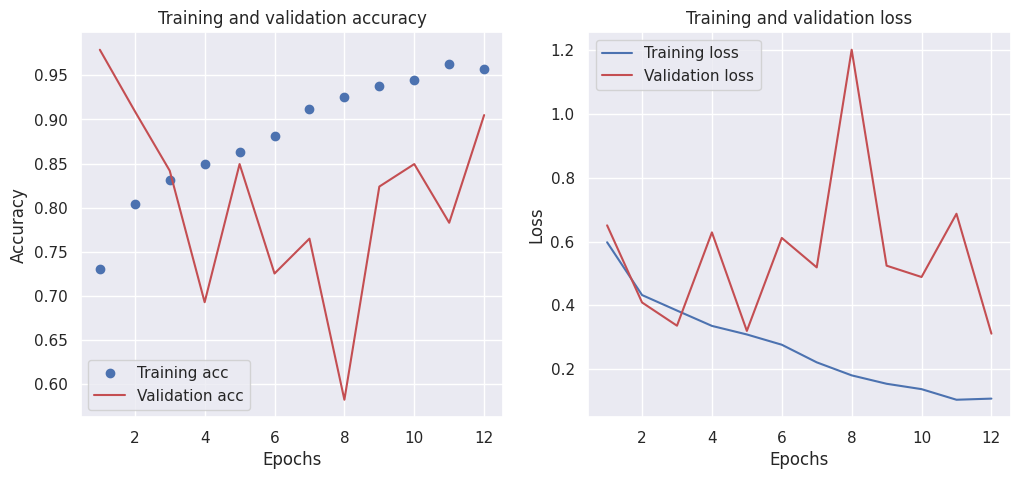

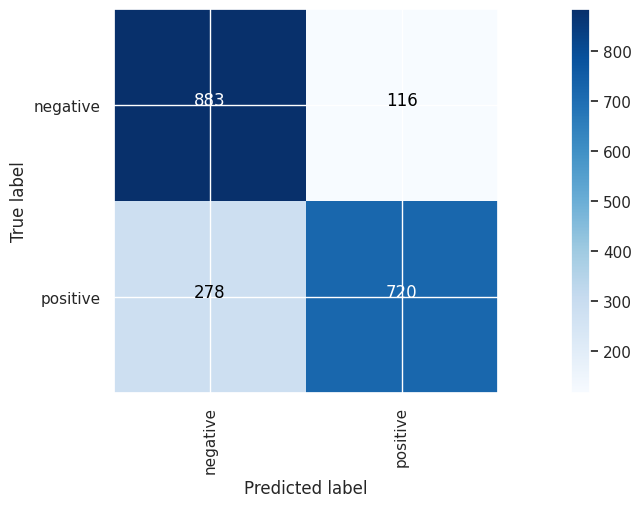

Final Accuracy
0.8027040560841262
Model: "Exp03ConvResidualConnections"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_43 (InputLayer)       [(None, 5000, 1)]            0         []                            
                                                                                                  
 conv1d_303 (Conv1D)         (None, 4997, 32)             160       ['input_43[0][0]']            
                                                                                                  
 batch_normalization_174 (B  (None, 4997, 32)             128       ['conv1d_303[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 conv1d_304 (Conv1D)         (None, 4

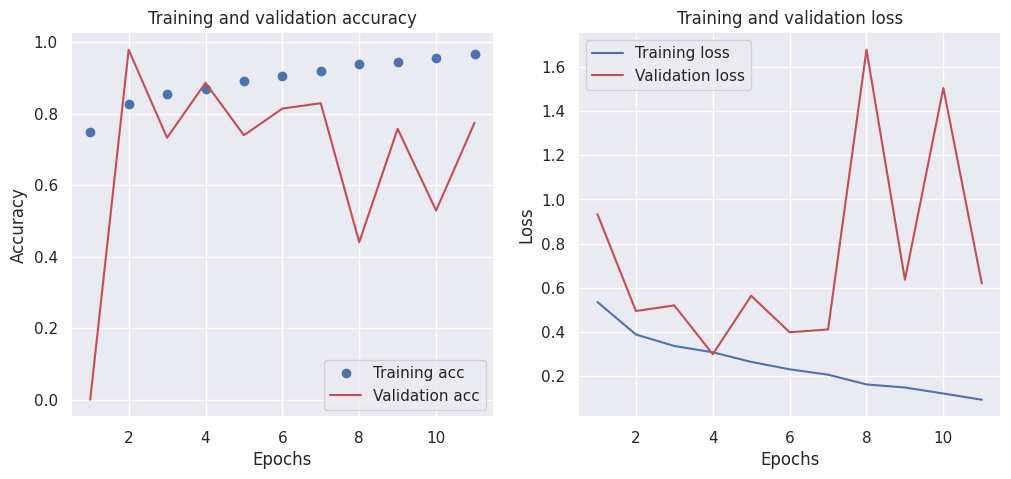

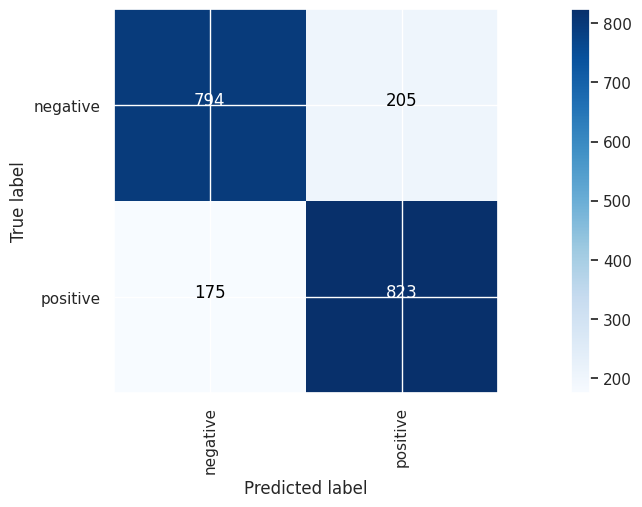

Final Accuracy
0.8097145718577867
Model: "Exp03ConvResidualConnections"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_44 (InputLayer)       [(None, 5000, 1)]            0         []                            
                                                                                                  
 conv1d_313 (Conv1D)         (None, 4997, 32)             160       ['input_44[0][0]']            
                                                                                                  
 batch_normalization_180 (B  (None, 4997, 32)             128       ['conv1d_313[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 conv1d_314 (Conv1D)         (None, 4

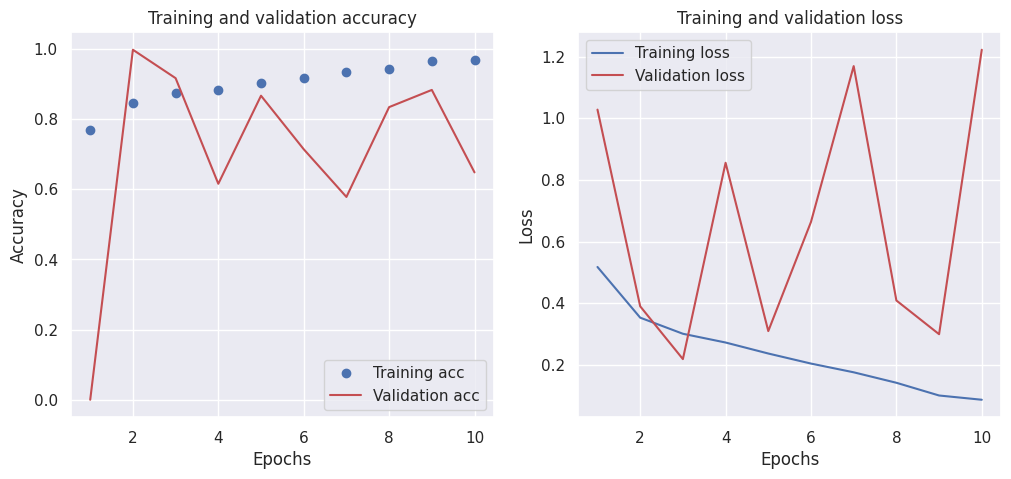

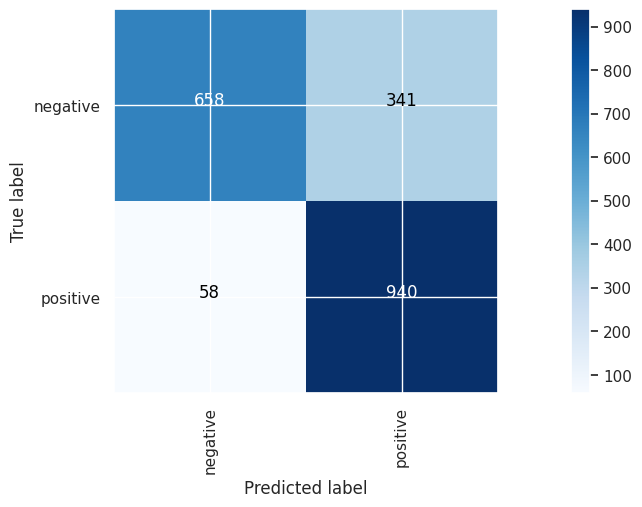

Final Accuracy
0.800200300450676
Model: "Exp03ConvResidualConnections"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_45 (InputLayer)       [(None, 600)]                0         []                            
                                                                                                  
 embedding_14 (Embedding)    (None, 600, 50)              1488650   ['input_45[0][0]']            
                                                                                                  
 conv1d_323 (Conv1D)         (None, 597, 32)              6432      ['embedding_14[0][0]']        
                                                                                                  
 batch_normalization_186 (B  (None, 597, 32)              128       ['conv1d_323[0][0]']          
 atchNormalization)                   

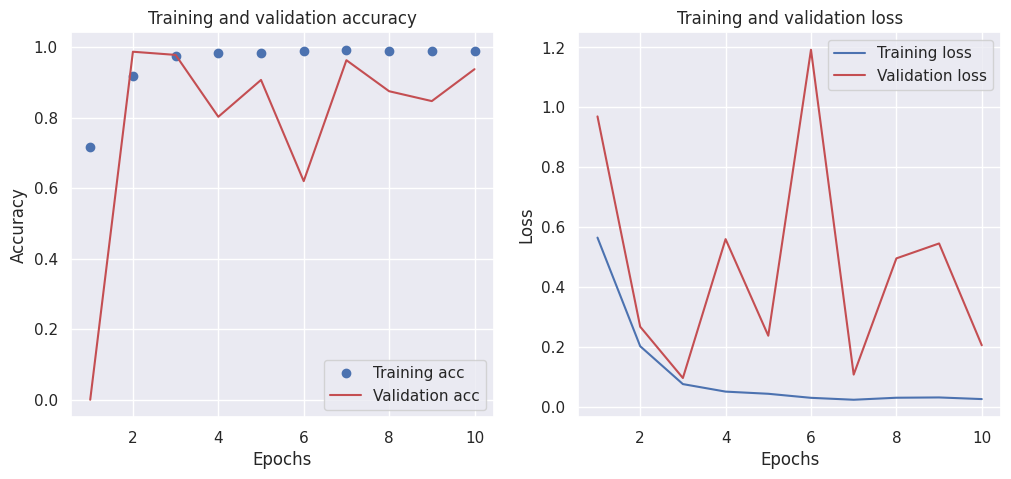

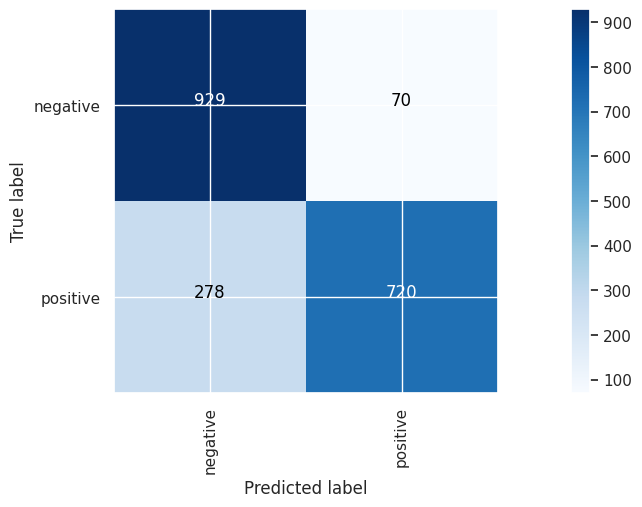

Final Accuracy
0.8257386079118678
Model: "Exp03ConvResidualConnections"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_46 (InputLayer)       [(None, 600)]                0         []                            
                                                                                                  
 embedding_15 (Embedding)    (None, 600, 50)              1488650   ['input_46[0][0]']            
                                                                                                  
 conv1d_333 (Conv1D)         (None, 597, 32)              6432      ['embedding_15[0][0]']        
                                                                                                  
 batch_normalization_192 (B  (None, 597, 32)              128       ['conv1d_333[0][0]']          
 atchNormalization)                  

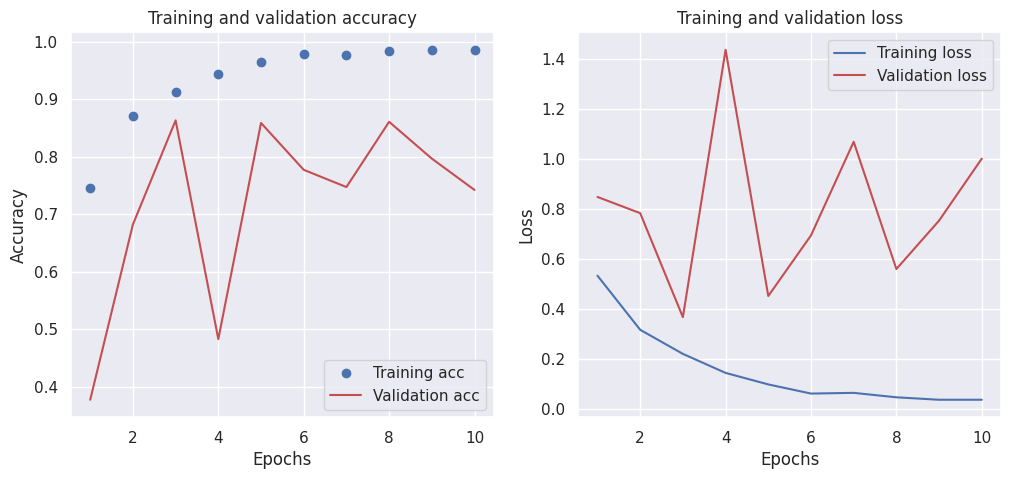

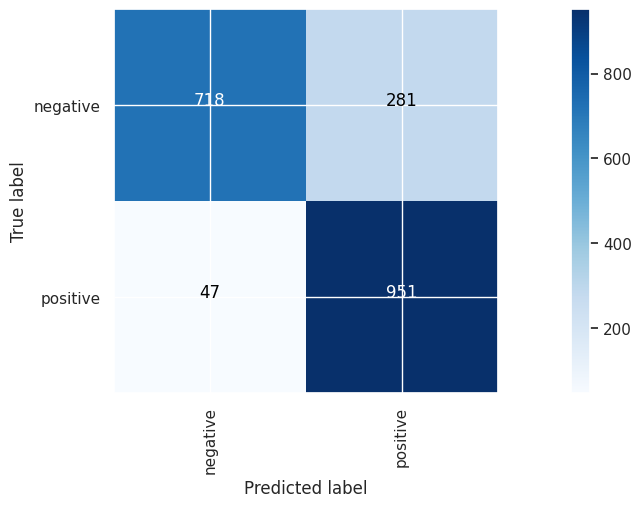

Final Accuracy
0.8357536304456685


In [38]:
# VSM models
results = []
name = "ConvResidualConnections"
description =   """
                number_of_filters=[32,64,128],
                kernel_size=4,
                dense_neurons=128,
                dropout=0.0, 
                pooling_size=4
                """
description = description.replace('\t', '').replace('\n', '').replace(' ', '')

number_of_filters=[32,64,128]
kernel_size=4
dense_neurons=128
dropout=0.0
pooling_size=4

# VSM models
results = []
for rep in vsm_model:
    build_exp03(name,
                description, 
                rep, 
                input_shape=(5000,1,),
                number_of_filters=number_of_filters,
                kernel_size=kernel_size,
                dense_neurons=dense_neurons,
                dropout=dropout, 
                pooling_size=pooling_size
                )

# Embedding with padding
embedding = layers.Embedding(input_dim=vocab_size,
                     output_dim=emb_dim,
                     trainable=True,
                     input_length=embedding_padding["train_text_features"].shape[1])
build_exp03(name,
            description, 
            embedding_padding, 
            input_shape=(embedding_padding["train_text_features"].shape[1],),
            embedding=embedding,
            number_of_filters=number_of_filters,
            kernel_size=kernel_size,
            dense_neurons=dense_neurons,
            dropout=dropout, 
            pooling_size=pooling_size        
            )

# GloVe
embedding = layers.Embedding(num_words,
                     emb_dim,
                     embeddings_initializer=Constant(embedding_glove["embedding_matrix"]),
                     trainable=True,
                     input_length=embedding_glove["train_text_features"].shape[1])

build_exp03(name,
            description, 
            embedding_glove, 
            input_shape=(embedding_glove["train_text_features"].shape[1],),
            embedding=embedding,
            number_of_filters=number_of_filters,
            kernel_size=kernel_size,
            dense_neurons=dense_neurons,
            dropout=dropout, 
            pooling_size=pooling_size        
            )
partial = pd.DataFrame(results)
partial.to_csv("exp_03_5.csv", index=False)

Model: "Exp03ConvResidualConnections"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_47 (InputLayer)       [(None, 5000, 1)]            0         []                            
                                                                                                  
 conv1d_343 (Conv1D)         (None, 4997, 32)             160       ['input_47[0][0]']            
                                                                                                  
 batch_normalization_198 (B  (None, 4997, 32)             128       ['conv1d_343[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 conv1d_344 (Conv1D)         (None, 4997, 32)             4128      ['b

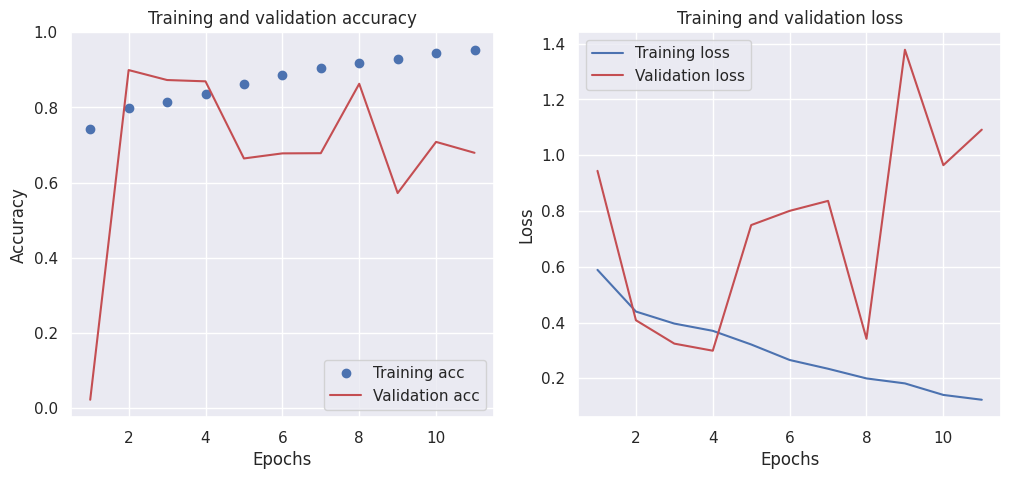

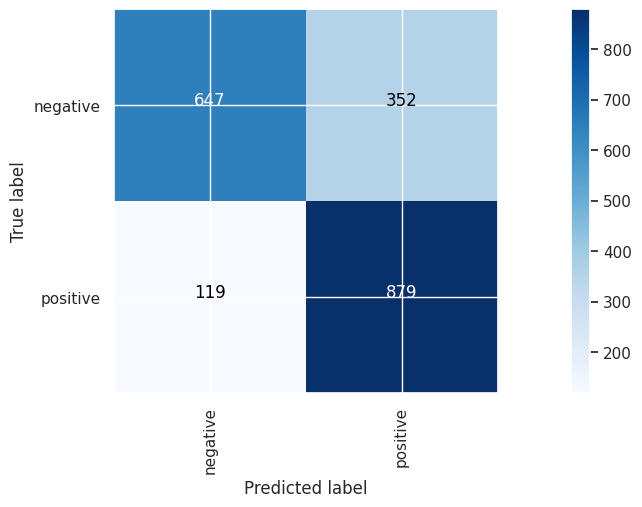

Final Accuracy
0.7641462193289935
Model: "Exp03ConvResidualConnections"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_48 (InputLayer)       [(None, 5000, 1)]            0         []                            
                                                                                                  
 conv1d_353 (Conv1D)         (None, 4997, 32)             160       ['input_48[0][0]']            
                                                                                                  
 batch_normalization_204 (B  (None, 4997, 32)             128       ['conv1d_353[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 conv1d_354 (Conv1D)         (None, 4

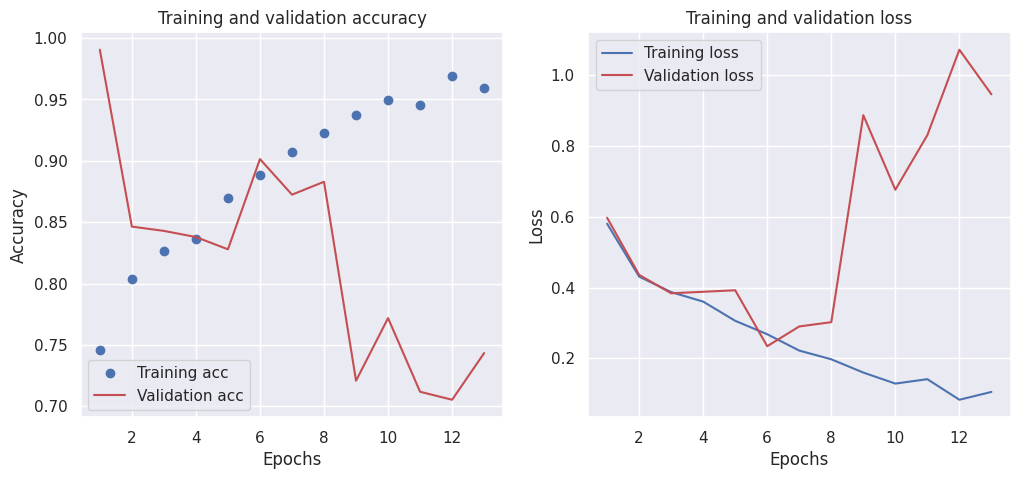

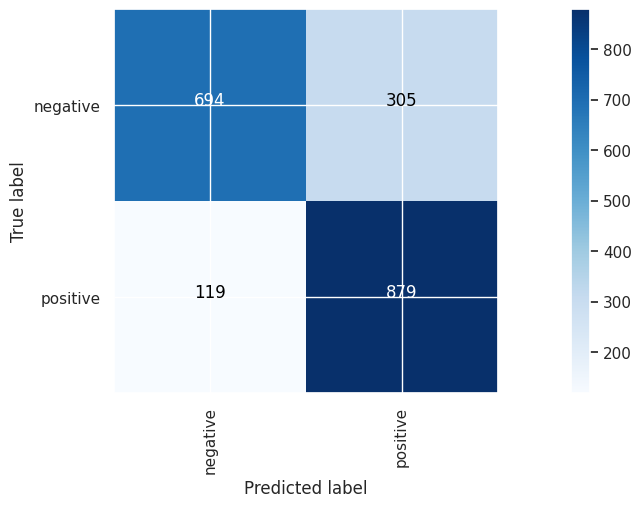

Final Accuracy
0.7876815222834251
Model: "Exp03ConvResidualConnections"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_49 (InputLayer)       [(None, 5000, 1)]            0         []                            
                                                                                                  
 conv1d_363 (Conv1D)         (None, 4997, 32)             160       ['input_49[0][0]']            
                                                                                                  
 batch_normalization_210 (B  (None, 4997, 32)             128       ['conv1d_363[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 conv1d_364 (Conv1D)         (None, 4

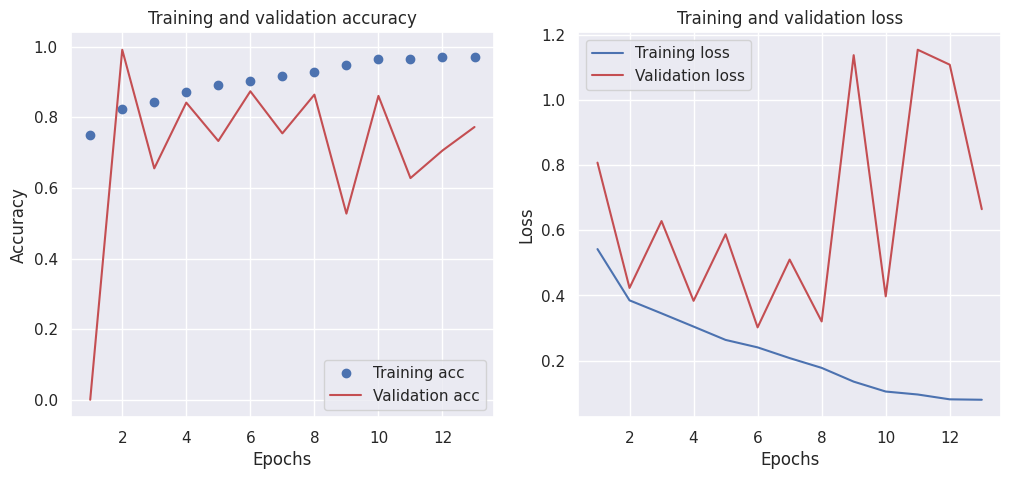

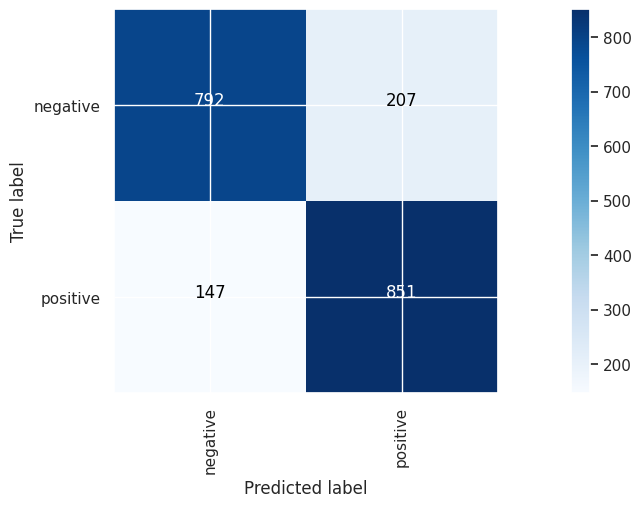

Final Accuracy
0.8227341011517276
Model: "Exp03ConvResidualConnections"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_50 (InputLayer)       [(None, 5000, 1)]            0         []                            
                                                                                                  
 conv1d_373 (Conv1D)         (None, 4997, 32)             160       ['input_50[0][0]']            
                                                                                                  
 batch_normalization_216 (B  (None, 4997, 32)             128       ['conv1d_373[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 conv1d_374 (Conv1D)         (None, 4

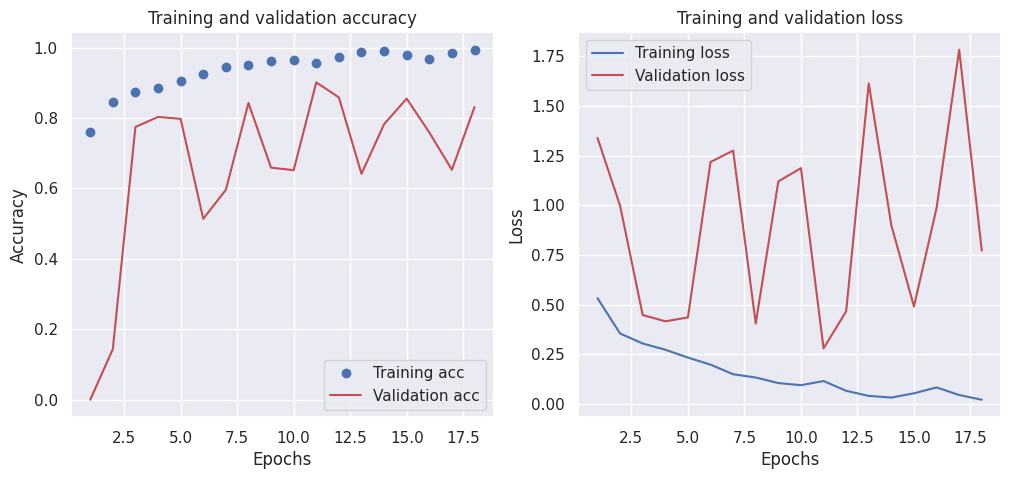

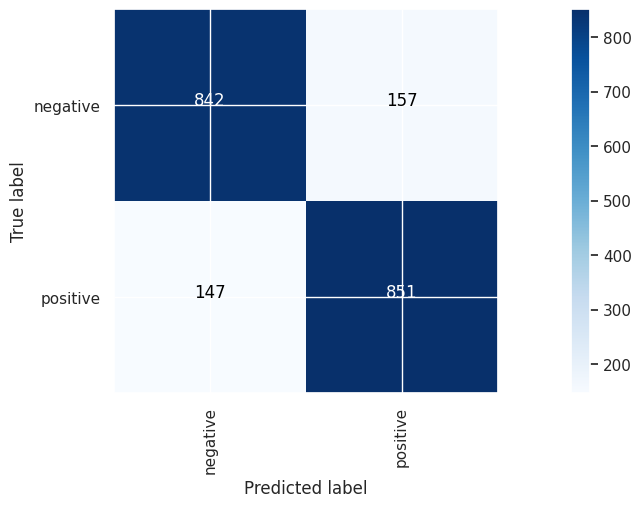

Final Accuracy
0.8477716574862293
Model: "Exp03ConvResidualConnections"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_51 (InputLayer)       [(None, 600)]                0         []                            
                                                                                                  
 embedding_16 (Embedding)    (None, 600, 50)              1488650   ['input_51[0][0]']            
                                                                                                  
 conv1d_383 (Conv1D)         (None, 597, 32)              6432      ['embedding_16[0][0]']        
                                                                                                  
 batch_normalization_222 (B  (None, 597, 32)              128       ['conv1d_383[0][0]']          
 atchNormalization)                  

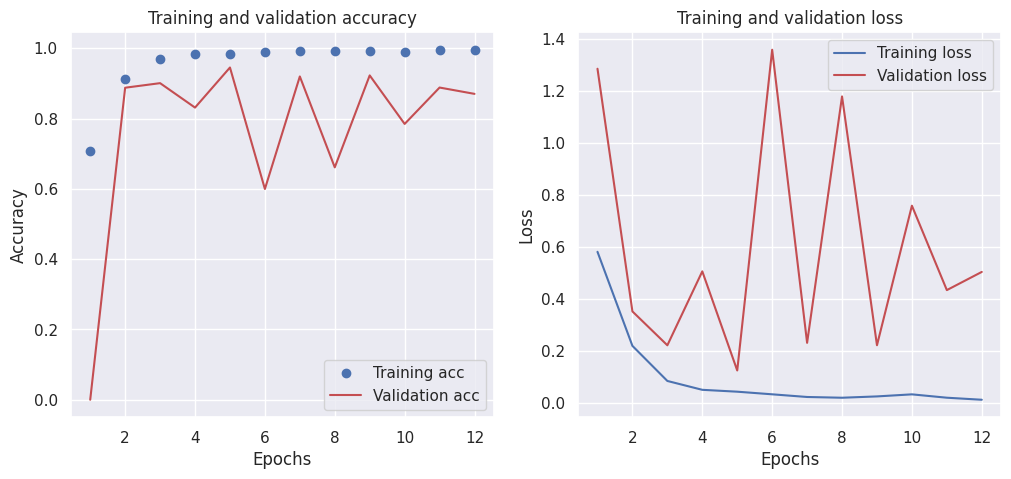

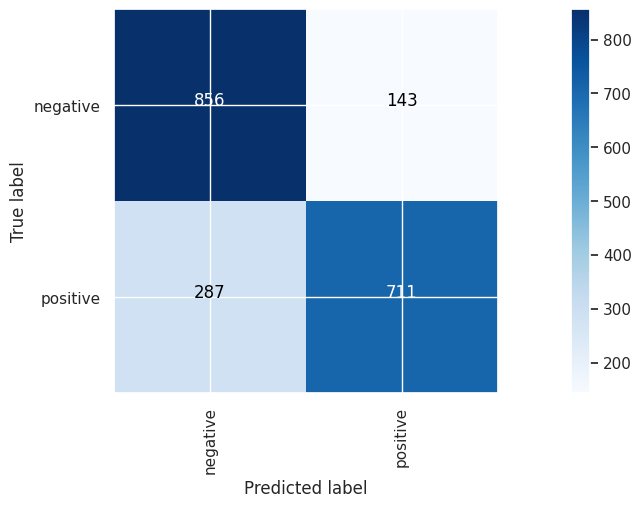

Final Accuracy
0.784677015523285
Model: "Exp03ConvResidualConnections"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_52 (InputLayer)       [(None, 600)]                0         []                            
                                                                                                  
 embedding_17 (Embedding)    (None, 600, 50)              1488650   ['input_52[0][0]']            
                                                                                                  
 conv1d_393 (Conv1D)         (None, 597, 32)              6432      ['embedding_17[0][0]']        
                                                                                                  
 batch_normalization_228 (B  (None, 597, 32)              128       ['conv1d_393[0][0]']          
 atchNormalization)                   

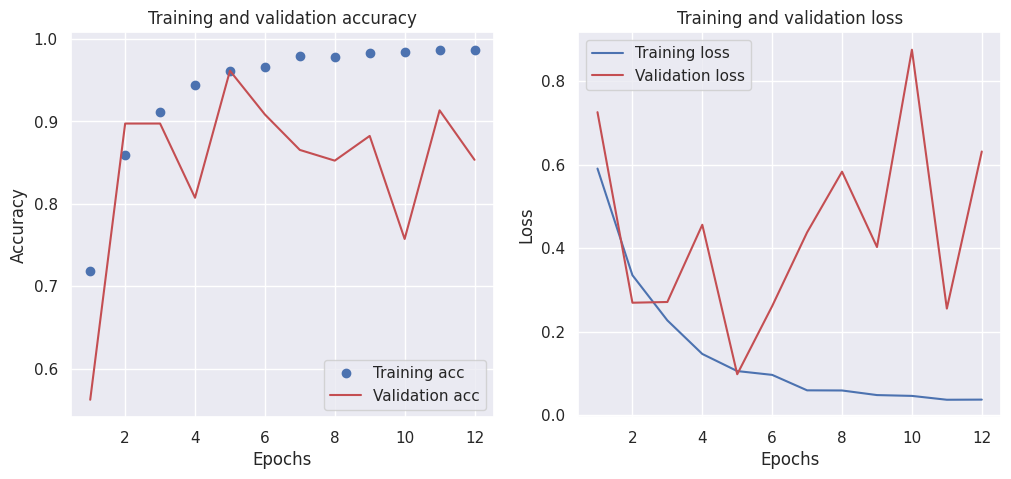

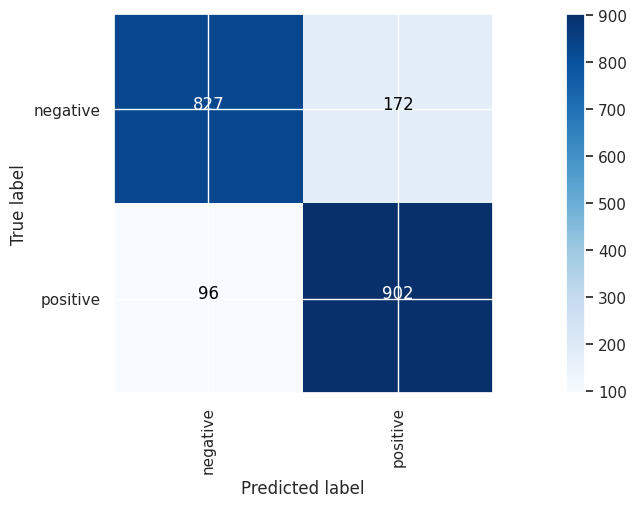

Final Accuracy
0.8657986980470707


In [39]:
# VSM models
results = []
name = "ConvResidualConnections"
description =   """
                number_of_filters=[32,64,128],
                kernel_size=4,
                dense_neurons=64,
                dropout=0.0, 
                pooling_size=4
                """
description = description.replace('\t', '').replace('\n', '').replace(' ', '')

number_of_filters=[32,64,128]
kernel_size=4
dense_neurons=64
dropout=0.0
pooling_size=4

# VSM models
results = []
for rep in vsm_model:
    build_exp03(name,
                description, 
                rep, 
                input_shape=(5000,1,),
                number_of_filters=number_of_filters,
                kernel_size=kernel_size,
                dense_neurons=dense_neurons,
                dropout=dropout, 
                pooling_size=pooling_size
                )

# Embedding with padding
embedding = layers.Embedding(input_dim=vocab_size,
                     output_dim=emb_dim,
                     trainable=True,
                     input_length=embedding_padding["train_text_features"].shape[1])
build_exp03(name,
            description, 
            embedding_padding, 
            input_shape=(embedding_padding["train_text_features"].shape[1],),
            embedding=embedding,
            number_of_filters=number_of_filters,
            kernel_size=kernel_size,
            dense_neurons=dense_neurons,
            dropout=dropout, 
            pooling_size=pooling_size        
            )

# GloVe
embedding = layers.Embedding(num_words,
                     emb_dim,
                     embeddings_initializer=Constant(embedding_glove["embedding_matrix"]),
                     trainable=True,
                     input_length=embedding_glove["train_text_features"].shape[1])

build_exp03(name,
            description, 
            embedding_glove, 
            input_shape=(embedding_glove["train_text_features"].shape[1],),
            embedding=embedding,
            number_of_filters=number_of_filters,
            kernel_size=kernel_size,
            dense_neurons=dense_neurons,
            dropout=dropout, 
            pooling_size=pooling_size        
            )
partial = pd.DataFrame(results)
partial.to_csv("exp_03_6.csv", index=False)

Model: "Exp03ConvResidualConnections"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_53 (InputLayer)       [(None, 5000, 1)]            0         []                            
                                                                                                  
 conv1d_403 (Conv1D)         (None, 4997, 32)             160       ['input_53[0][0]']            
                                                                                                  
 batch_normalization_234 (B  (None, 4997, 32)             128       ['conv1d_403[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 conv1d_404 (Conv1D)         (None, 4997, 32)             4128      ['b

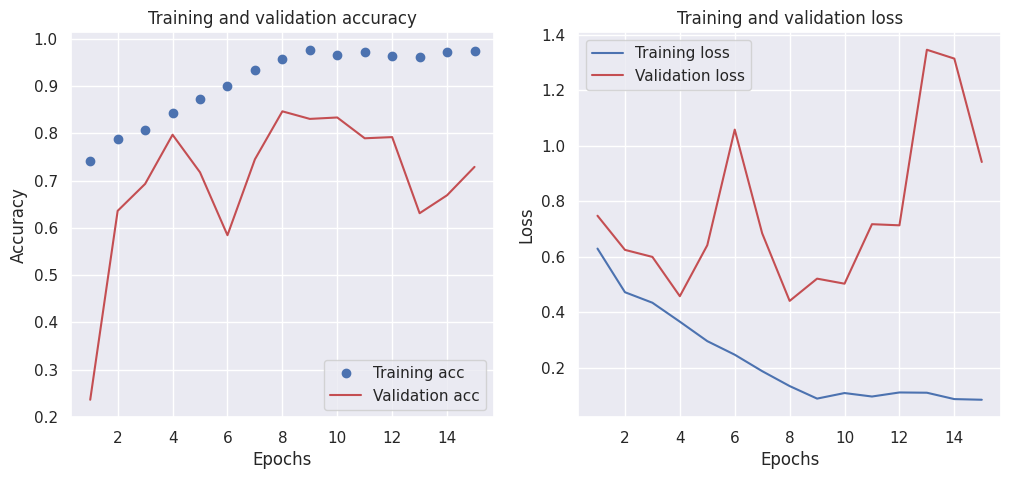

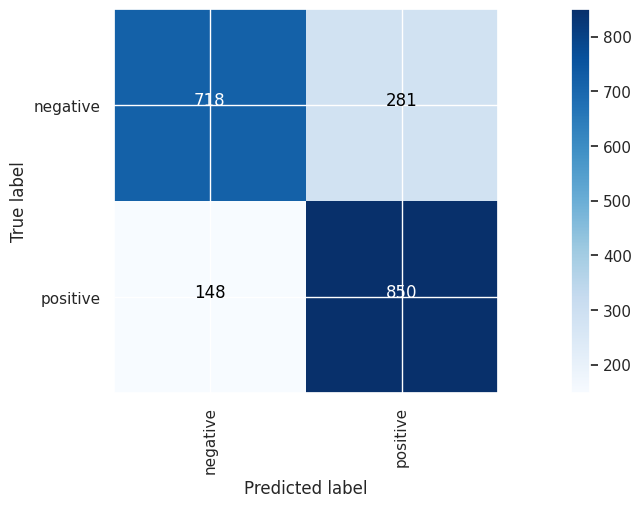

Final Accuracy
0.785177766649975
Model: "Exp03ConvResidualConnections"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_54 (InputLayer)       [(None, 5000, 1)]            0         []                            
                                                                                                  
 conv1d_413 (Conv1D)         (None, 4997, 32)             160       ['input_54[0][0]']            
                                                                                                  
 batch_normalization_240 (B  (None, 4997, 32)             128       ['conv1d_413[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 conv1d_414 (Conv1D)         (None, 49

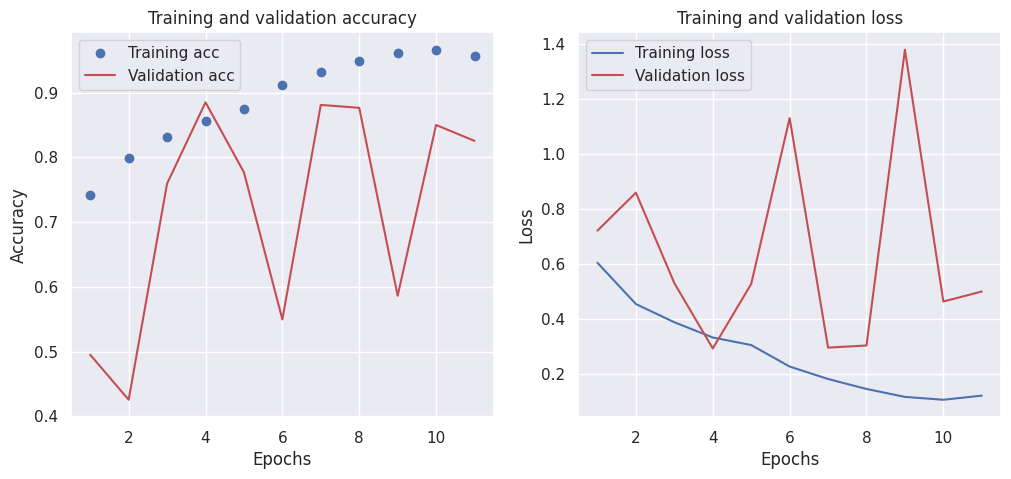

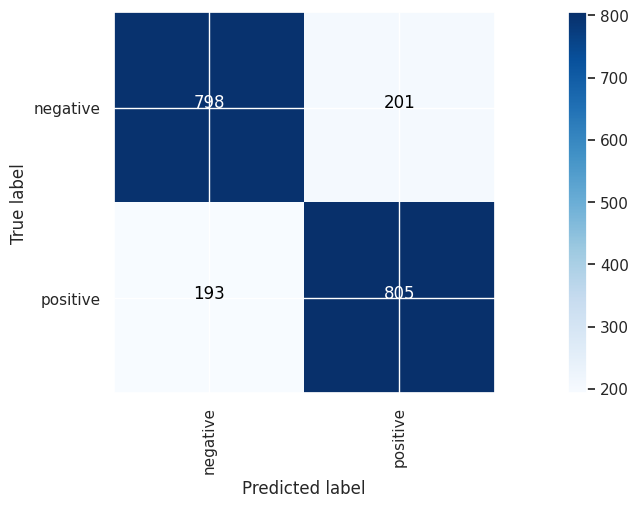

Final Accuracy
0.8027040560841262
Model: "Exp03ConvResidualConnections"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_55 (InputLayer)       [(None, 5000, 1)]            0         []                            
                                                                                                  
 conv1d_423 (Conv1D)         (None, 4997, 32)             160       ['input_55[0][0]']            
                                                                                                  
 batch_normalization_246 (B  (None, 4997, 32)             128       ['conv1d_423[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 conv1d_424 (Conv1D)         (None, 4

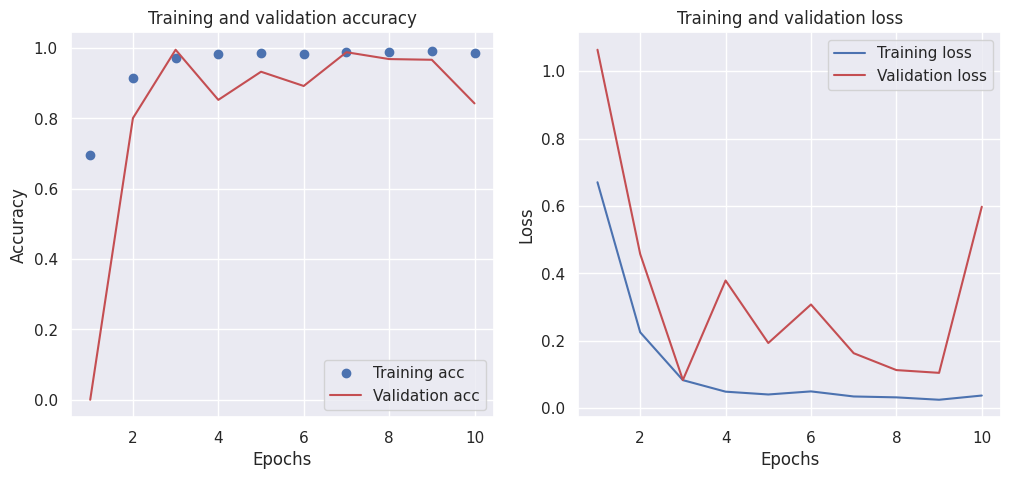

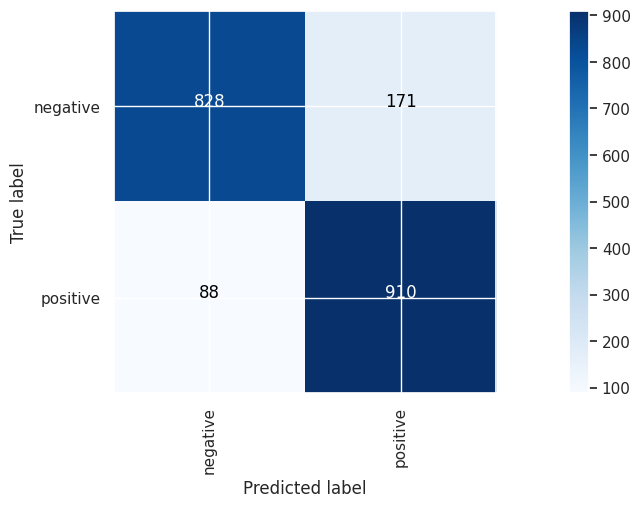

Final Accuracy
0.8703054581872809
Model: "Exp03ConvResidualConnections"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_58 (InputLayer)       [(None, 600)]                0         []                            
                                                                                                  
 embedding_19 (Embedding)    (None, 600, 50)              1488650   ['input_58[0][0]']            
                                                                                                  
 conv1d_453 (Conv1D)         (None, 597, 32)              6432      ['embedding_19[0][0]']        
                                                                                                  
 batch_normalization_264 (B  (None, 597, 32)              128       ['conv1d_453[0][0]']          
 atchNormalization)                  

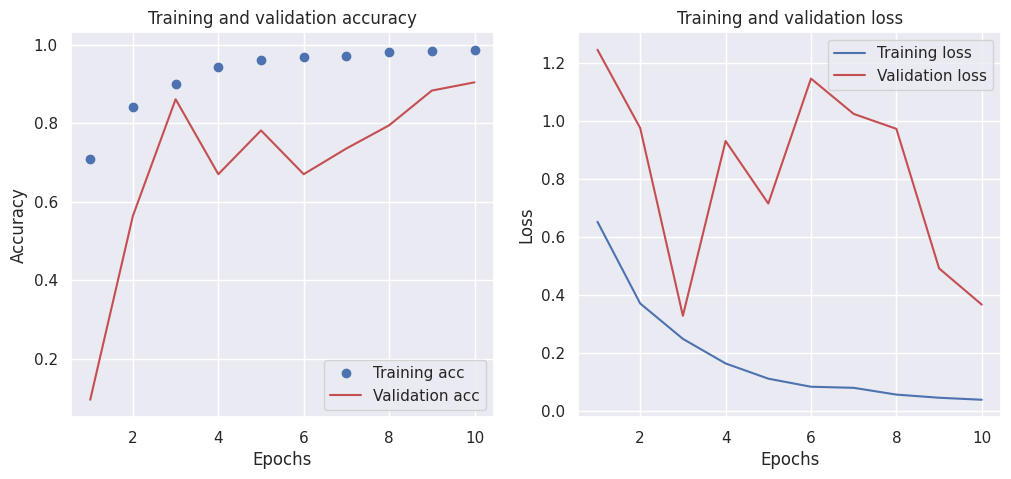

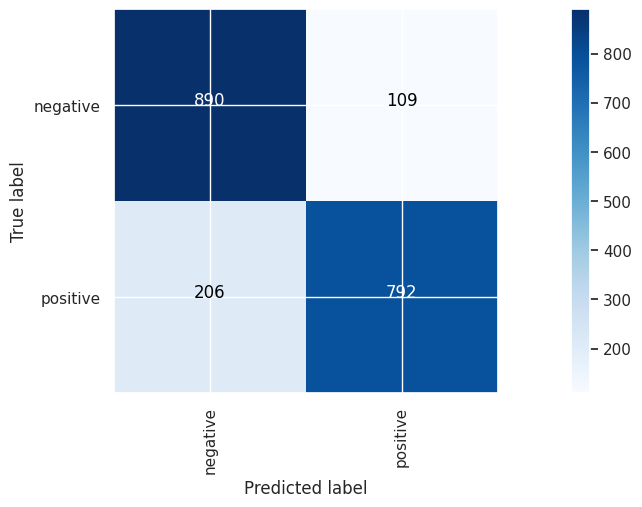

Final Accuracy
0.8422633950926389


In [40]:
# VSM models
results = []
name = "ConvResidualConnections"
description =   """
                number_of_filters=[32,64,128],
                kernel_size=4,
                dense_neurons=0,
                dropout=0.0, 
                pooling_size=4
                """
description = description.replace('\t', '').replace('\n', '').replace(' ', '')

number_of_filters=[32,64,128]
kernel_size=4
dense_neurons=0
dropout=0.0
pooling_size=4

# VSM models
results = []
for rep in vsm_model:
    build_exp03(name,
                description, 
                rep, 
                input_shape=(5000,1,),
                number_of_filters=number_of_filters,
                kernel_size=kernel_size,
                dense_neurons=dense_neurons,
                dropout=dropout, 
                pooling_size=pooling_size
                )

# Embedding with padding
embedding = layers.Embedding(input_dim=vocab_size,
                     output_dim=emb_dim,
                     trainable=True,
                     input_length=embedding_padding["train_text_features"].shape[1])
build_exp03(name,
            description, 
            embedding_padding, 
            input_shape=(embedding_padding["train_text_features"].shape[1],),
            embedding=embedding,
            number_of_filters=number_of_filters,
            kernel_size=kernel_size,
            dense_neurons=dense_neurons,
            dropout=dropout, 
            pooling_size=pooling_size        
            )

# GloVe
embedding = layers.Embedding(num_words,
                     emb_dim,
                     embeddings_initializer=Constant(embedding_glove["embedding_matrix"]),
                     trainable=True,
                     input_length=embedding_glove["train_text_features"].shape[1])

build_exp03(name,
            description, 
            embedding_glove, 
            input_shape=(embedding_glove["train_text_features"].shape[1],),
            embedding=embedding,
            number_of_filters=number_of_filters,
            kernel_size=kernel_size,
            dense_neurons=dense_neurons,
            dropout=dropout, 
            pooling_size=pooling_size        
            )
partial = pd.DataFrame(results)
partial.to_csv("exp_03_7.csv", index=False)

Model: "Exp03ConvResidualConnections"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_59 (InputLayer)       [(None, 5000, 1)]            0         []                            
                                                                                                  
 conv1d_463 (Conv1D)         (None, 4997, 32)             160       ['input_59[0][0]']            
                                                                                                  
 batch_normalization_270 (B  (None, 4997, 32)             128       ['conv1d_463[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 conv1d_464 (Conv1D)         (None, 4997, 32)             4128      ['b

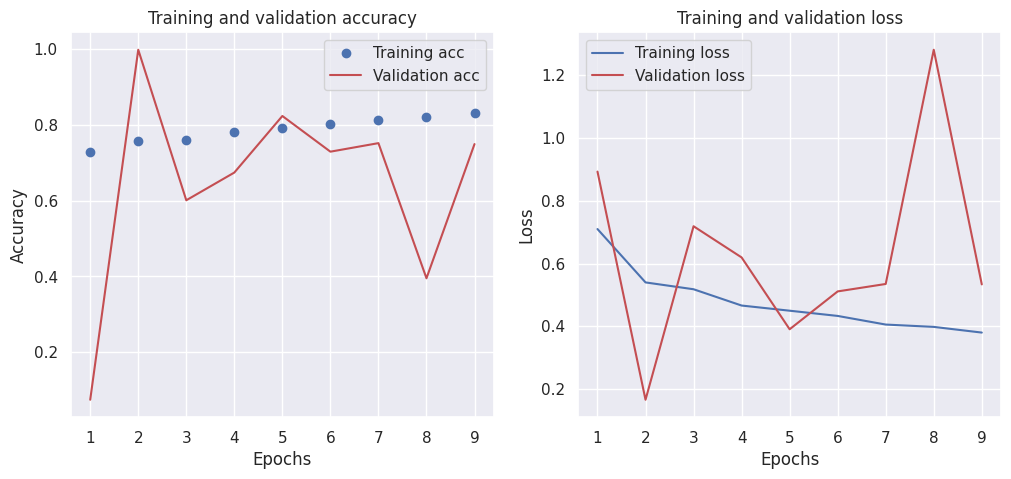

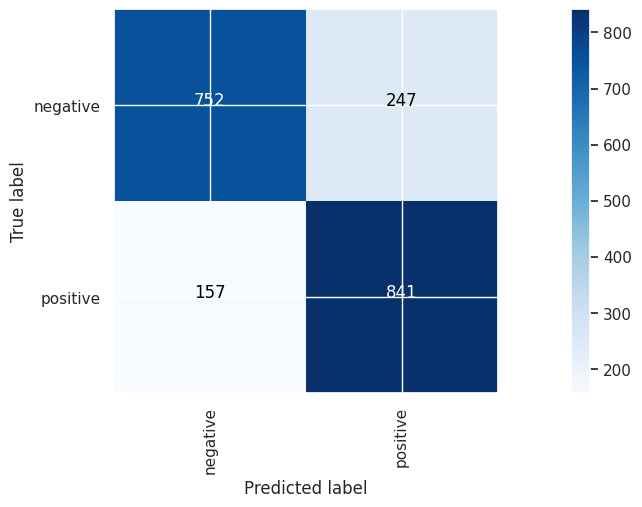

Final Accuracy
0.7976965448172258
Model: "Exp03ConvResidualConnections"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_60 (InputLayer)       [(None, 5000, 1)]            0         []                            
                                                                                                  
 conv1d_473 (Conv1D)         (None, 4997, 32)             160       ['input_60[0][0]']            
                                                                                                  
 batch_normalization_276 (B  (None, 4997, 32)             128       ['conv1d_473[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 conv1d_474 (Conv1D)         (None, 4

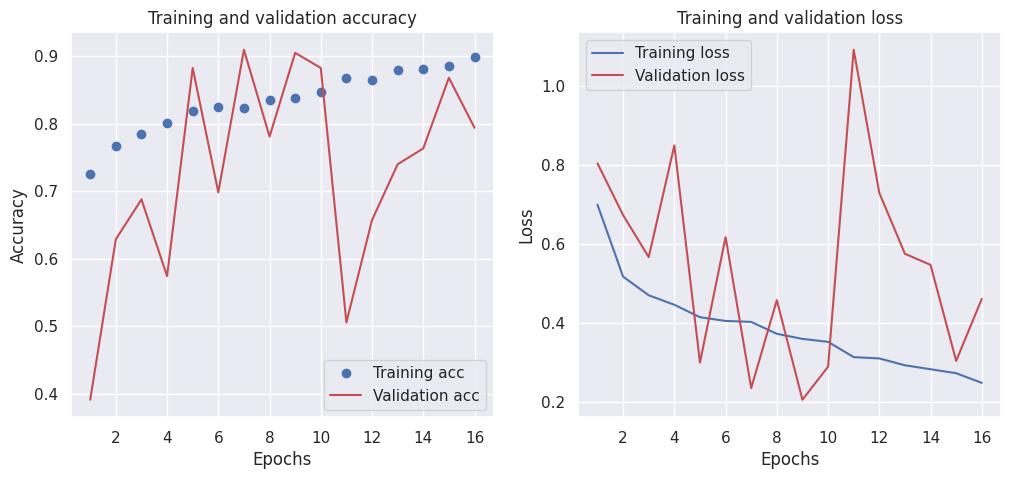

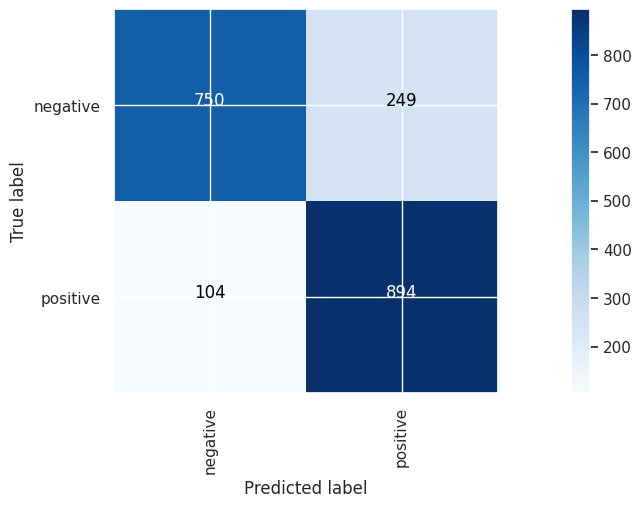

Final Accuracy
0.8232348522784176
Model: "Exp03ConvResidualConnections"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_61 (InputLayer)       [(None, 5000, 1)]            0         []                            
                                                                                                  
 conv1d_483 (Conv1D)         (None, 4997, 32)             160       ['input_61[0][0]']            
                                                                                                  
 batch_normalization_282 (B  (None, 4997, 32)             128       ['conv1d_483[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 conv1d_484 (Conv1D)         (None, 4

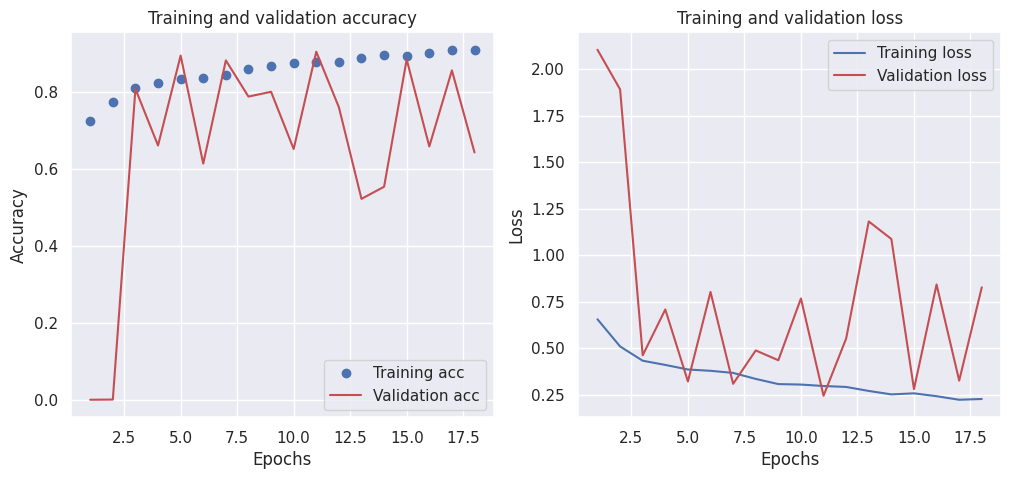

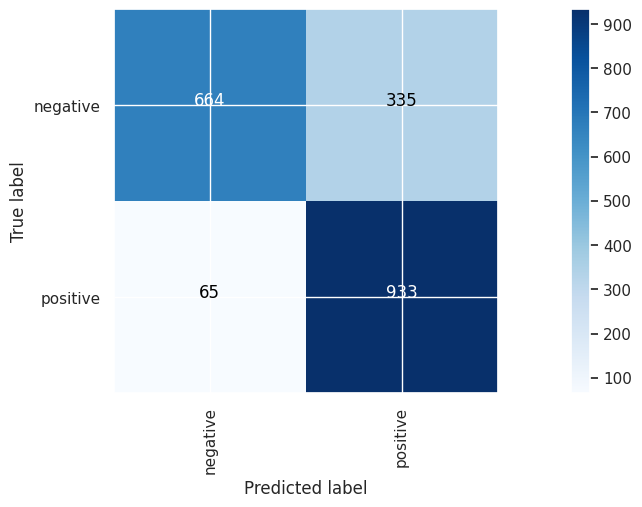

Final Accuracy
0.799699549323986
Model: "Exp03ConvResidualConnections"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_62 (InputLayer)       [(None, 5000, 1)]            0         []                            
                                                                                                  
 conv1d_493 (Conv1D)         (None, 4997, 32)             160       ['input_62[0][0]']            
                                                                                                  
 batch_normalization_288 (B  (None, 4997, 32)             128       ['conv1d_493[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 conv1d_494 (Conv1D)         (None, 49

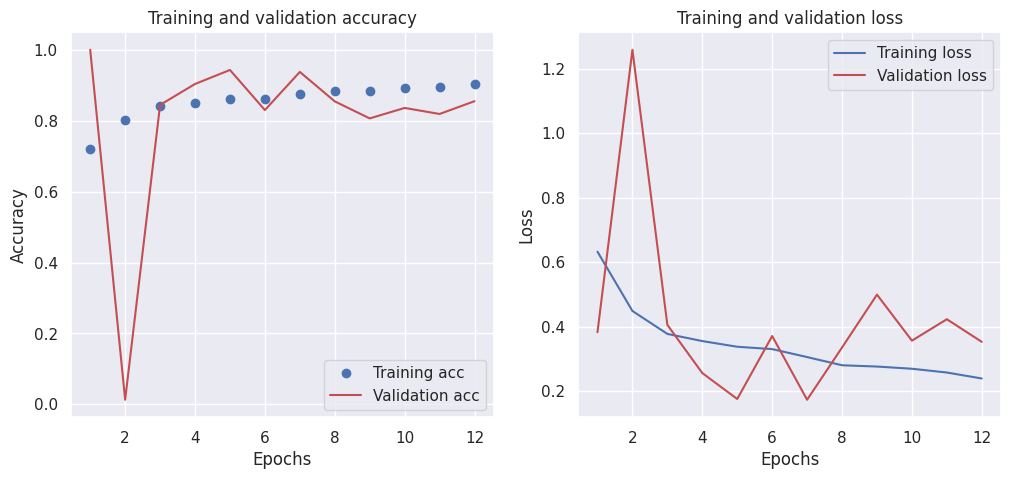

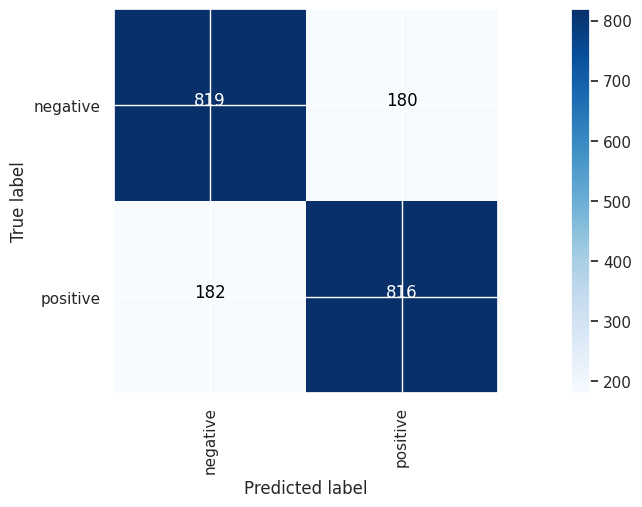

Final Accuracy
0.8187280921382073
Model: "Exp03ConvResidualConnections"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_63 (InputLayer)       [(None, 600)]                0         []                            
                                                                                                  
 embedding_20 (Embedding)    (None, 600, 50)              1488650   ['input_63[0][0]']            
                                                                                                  
 conv1d_503 (Conv1D)         (None, 597, 32)              6432      ['embedding_20[0][0]']        
                                                                                                  
 batch_normalization_294 (B  (None, 597, 32)              128       ['conv1d_503[0][0]']          
 atchNormalization)                  

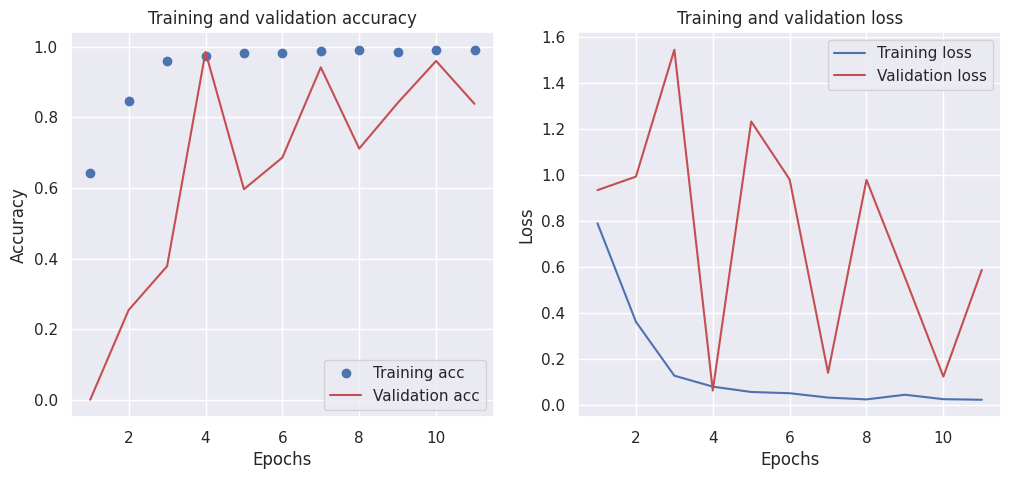

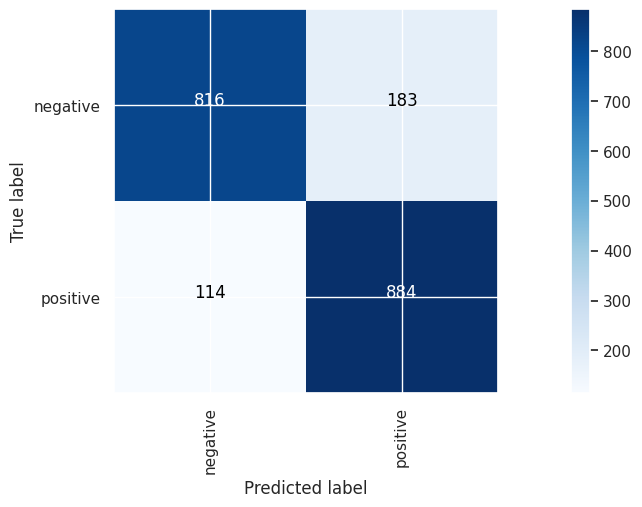

Final Accuracy
0.8512769153730596
Model: "Exp03ConvResidualConnections"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_64 (InputLayer)       [(None, 600)]                0         []                            
                                                                                                  
 embedding_21 (Embedding)    (None, 600, 50)              1488650   ['input_64[0][0]']            
                                                                                                  
 conv1d_513 (Conv1D)         (None, 597, 32)              6432      ['embedding_21[0][0]']        
                                                                                                  
 batch_normalization_300 (B  (None, 597, 32)              128       ['conv1d_513[0][0]']          
 atchNormalization)                  

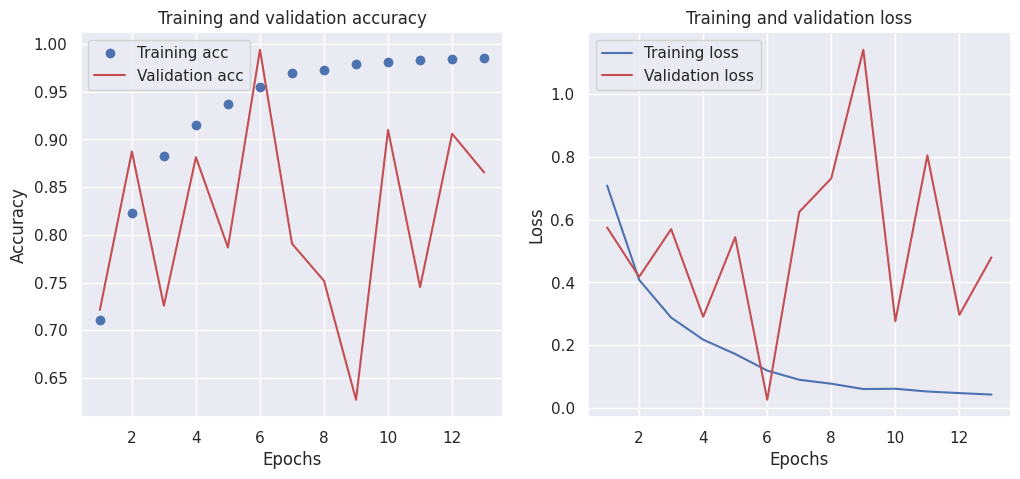

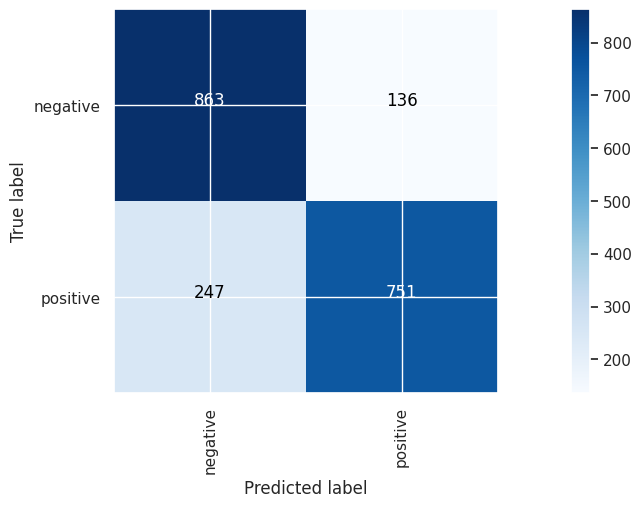

Final Accuracy
0.8082123184777166


In [41]:
# VSM models
results = []
name = "ConvResidualConnections"
description =   """
                number_of_filters=[32,64,128],
                kernel_size=4,
                dense_neurons=0,
                dropout=0.15, 
                pooling_size=4
                """
description = description.replace('\t', '').replace('\n', '').replace(' ', '')

number_of_filters=[32,64,128]
kernel_size=4
dense_neurons=0
dropout=0.15
pooling_size=4

# VSM models
results = []
for rep in vsm_model:
    build_exp03(name,
                description, 
                rep, 
                input_shape=(5000,1,),
                number_of_filters=number_of_filters,
                kernel_size=kernel_size,
                dense_neurons=dense_neurons,
                dropout=dropout, 
                pooling_size=pooling_size
                )

# Embedding with padding
embedding = layers.Embedding(input_dim=vocab_size,
                     output_dim=emb_dim,
                     trainable=True,
                     input_length=embedding_padding["train_text_features"].shape[1])
build_exp03(name,
            description, 
            embedding_padding, 
            input_shape=(embedding_padding["train_text_features"].shape[1],),
            embedding=embedding,
            number_of_filters=number_of_filters,
            kernel_size=kernel_size,
            dense_neurons=dense_neurons,
            dropout=dropout, 
            pooling_size=pooling_size        
            )

# GloVe
embedding = layers.Embedding(num_words,
                     emb_dim,
                     embeddings_initializer=Constant(embedding_glove["embedding_matrix"]),
                     trainable=True,
                     input_length=embedding_glove["train_text_features"].shape[1])

build_exp03(name,
            description, 
            embedding_glove, 
            input_shape=(embedding_glove["train_text_features"].shape[1],),
            embedding=embedding,
            number_of_filters=number_of_filters,
            kernel_size=kernel_size,
            dense_neurons=dense_neurons,
            dropout=dropout, 
            pooling_size=pooling_size        
            )
partial = pd.DataFrame(results)
partial.to_csv("exp_03_8.csv", index=False)

Model: "Exp03ConvResidualConnections"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_65 (InputLayer)       [(None, 5000, 1)]            0         []                            
                                                                                                  
 conv1d_523 (Conv1D)         (None, 4997, 32)             160       ['input_65[0][0]']            
                                                                                                  
 batch_normalization_306 (B  (None, 4997, 32)             128       ['conv1d_523[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 conv1d_524 (Conv1D)         (None, 4997, 32)             4128      ['b

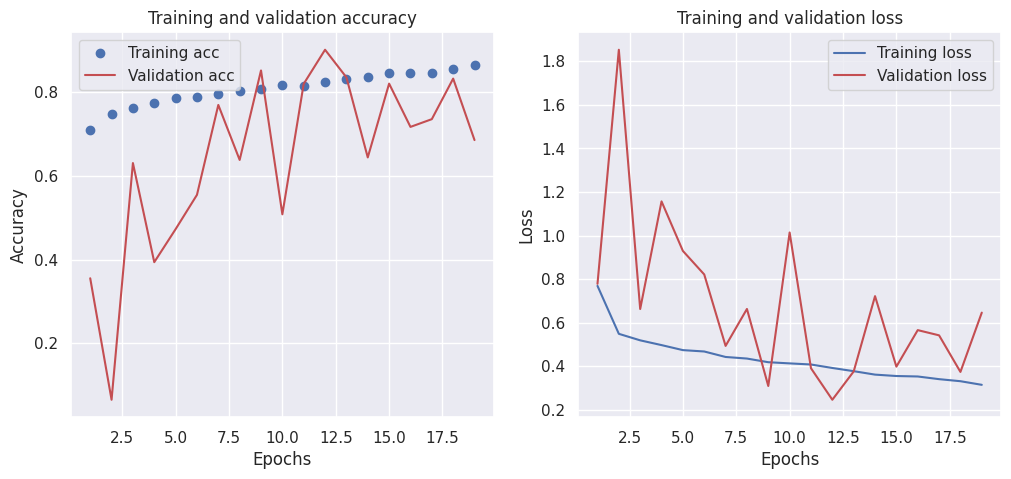

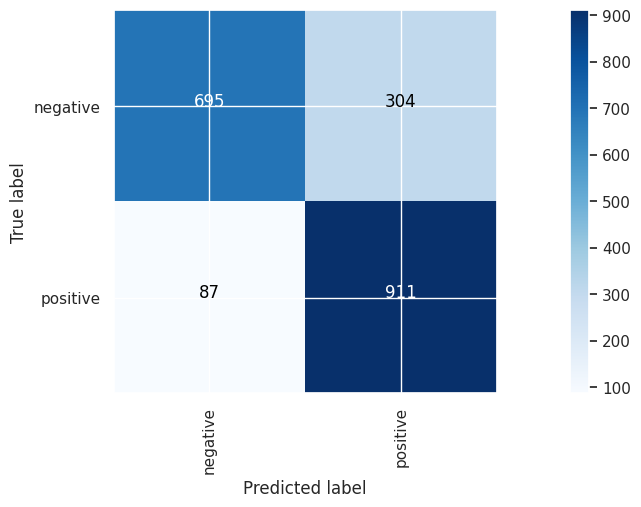

Final Accuracy
0.8042063094641962
Model: "Exp03ConvResidualConnections"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_66 (InputLayer)       [(None, 5000, 1)]            0         []                            
                                                                                                  
 conv1d_533 (Conv1D)         (None, 4997, 32)             160       ['input_66[0][0]']            
                                                                                                  
 batch_normalization_312 (B  (None, 4997, 32)             128       ['conv1d_533[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 conv1d_534 (Conv1D)         (None, 4

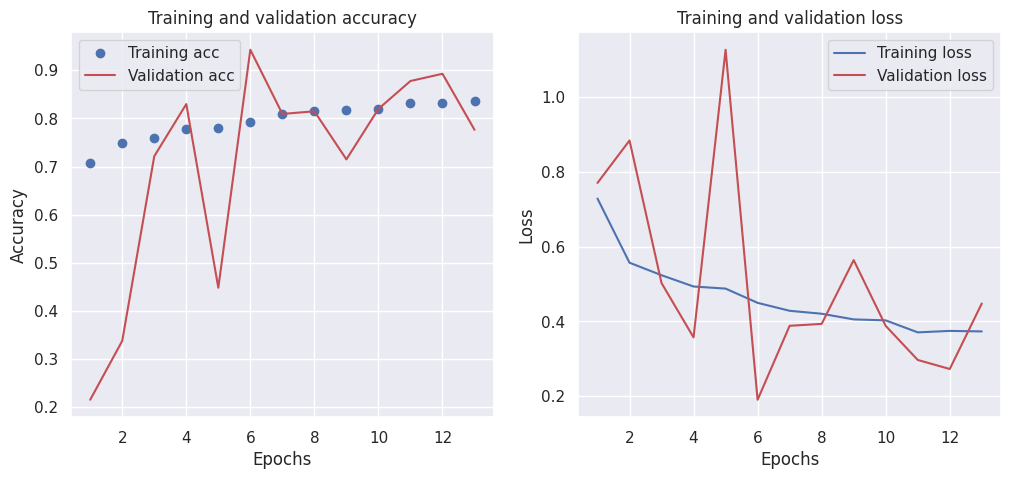

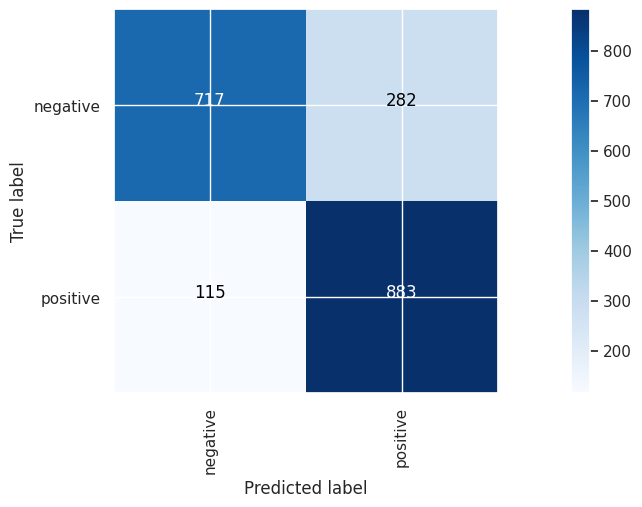

Final Accuracy
0.801201802704056
Model: "Exp03ConvResidualConnections"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_67 (InputLayer)       [(None, 5000, 1)]            0         []                            
                                                                                                  
 conv1d_543 (Conv1D)         (None, 4997, 32)             160       ['input_67[0][0]']            
                                                                                                  
 batch_normalization_318 (B  (None, 4997, 32)             128       ['conv1d_543[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 conv1d_544 (Conv1D)         (None, 49

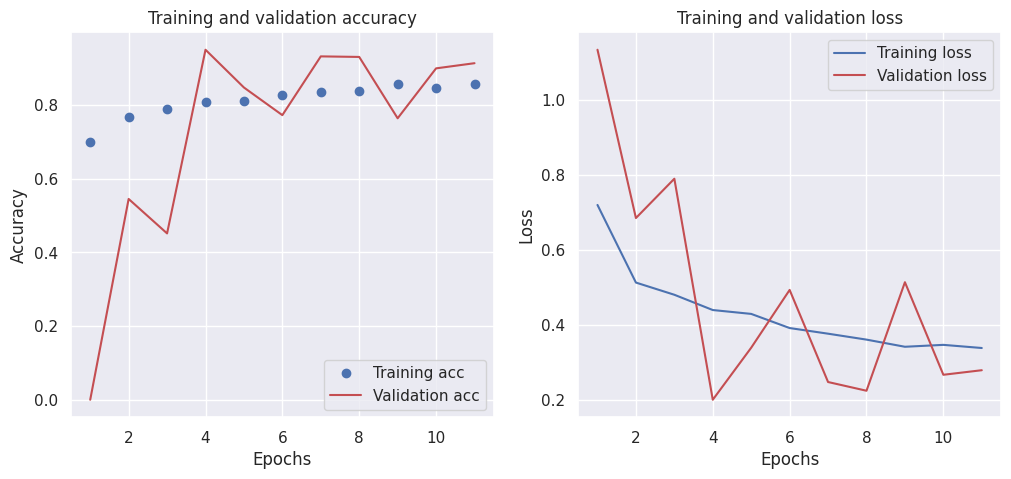

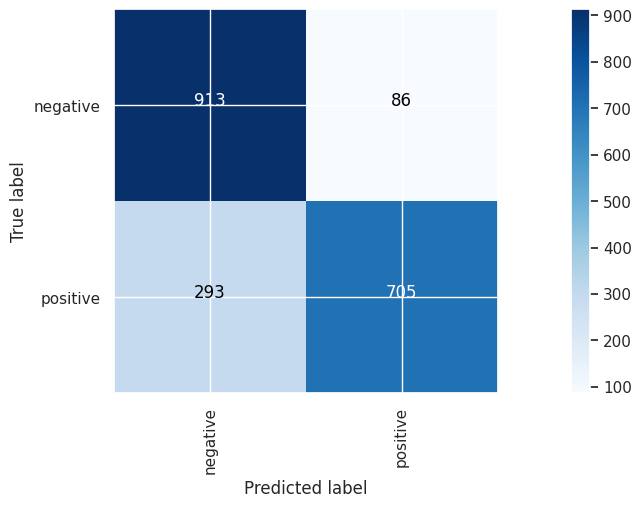

Final Accuracy
0.8102153229844767
Model: "Exp03ConvResidualConnections"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_68 (InputLayer)       [(None, 5000, 1)]            0         []                            
                                                                                                  
 conv1d_553 (Conv1D)         (None, 4997, 32)             160       ['input_68[0][0]']            
                                                                                                  
 batch_normalization_324 (B  (None, 4997, 32)             128       ['conv1d_553[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 conv1d_554 (Conv1D)         (None, 4

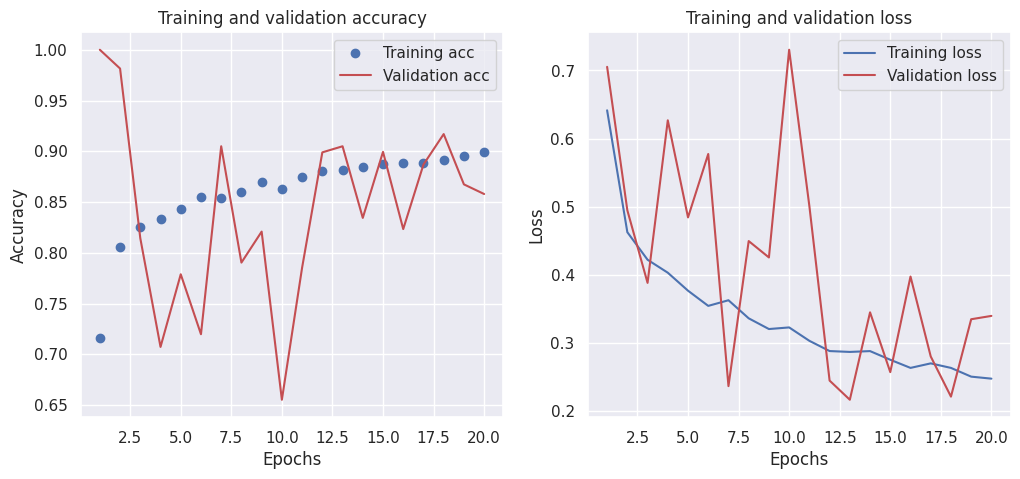

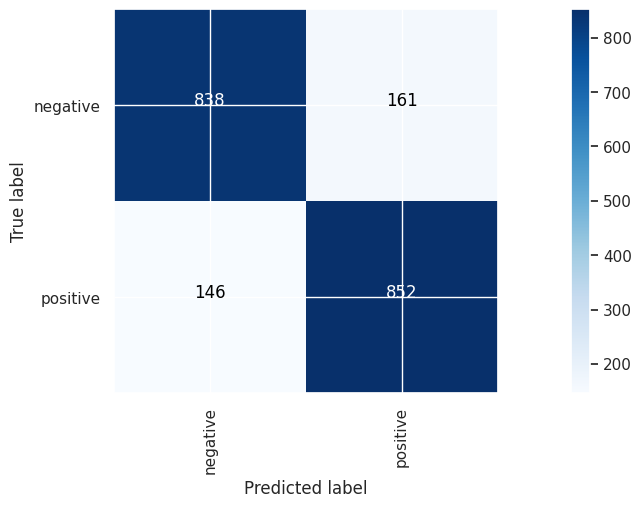

Final Accuracy
0.8462694041061593
Model: "Exp03ConvResidualConnections"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_69 (InputLayer)       [(None, 600)]                0         []                            
                                                                                                  
 embedding_22 (Embedding)    (None, 600, 50)              1488650   ['input_69[0][0]']            
                                                                                                  
 conv1d_563 (Conv1D)         (None, 597, 32)              6432      ['embedding_22[0][0]']        
                                                                                                  
 batch_normalization_330 (B  (None, 597, 32)              128       ['conv1d_563[0][0]']          
 atchNormalization)                  

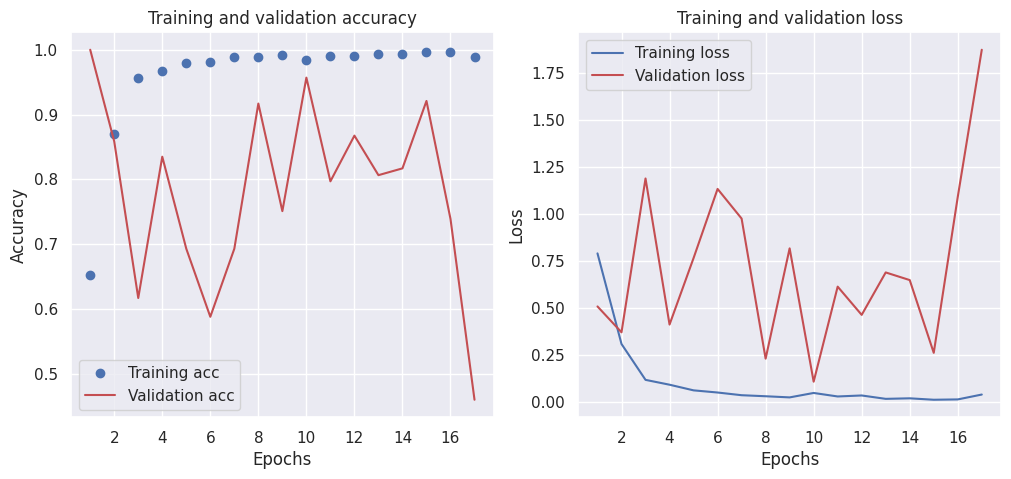

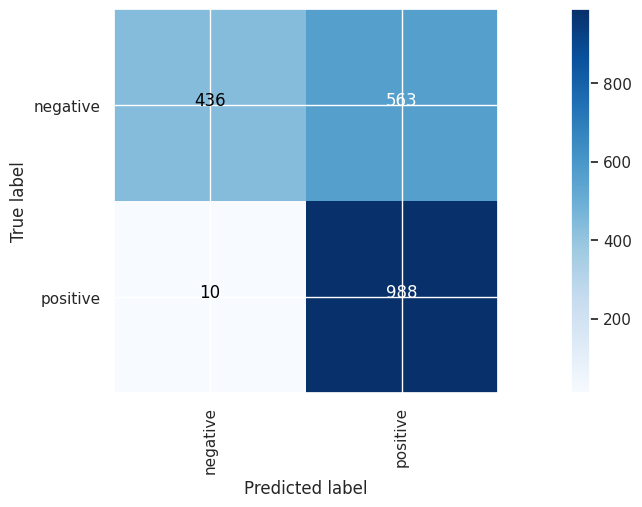

Final Accuracy
0.7130696044066099
Model: "Exp03ConvResidualConnections"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_70 (InputLayer)       [(None, 600)]                0         []                            
                                                                                                  
 embedding_23 (Embedding)    (None, 600, 50)              1488650   ['input_70[0][0]']            
                                                                                                  
 conv1d_573 (Conv1D)         (None, 597, 32)              6432      ['embedding_23[0][0]']        
                                                                                                  
 batch_normalization_336 (B  (None, 597, 32)              128       ['conv1d_573[0][0]']          
 atchNormalization)                  

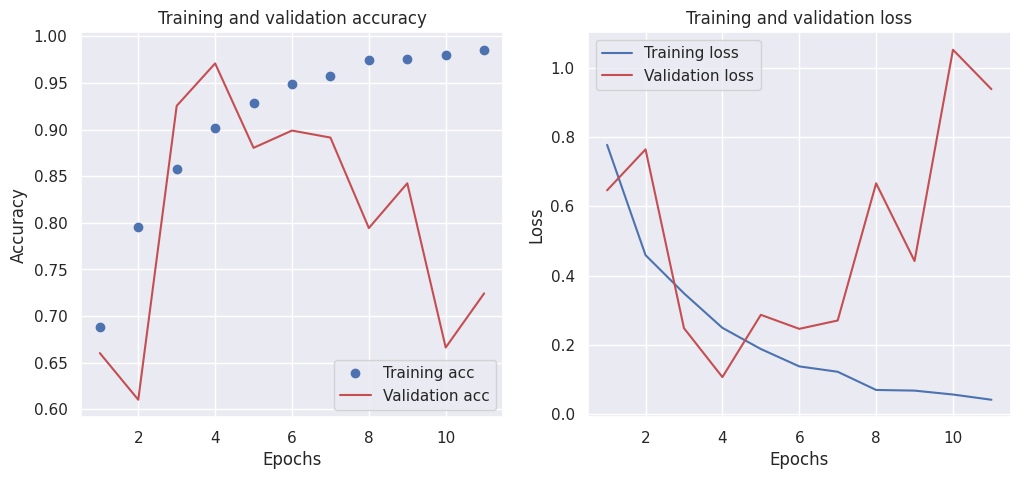

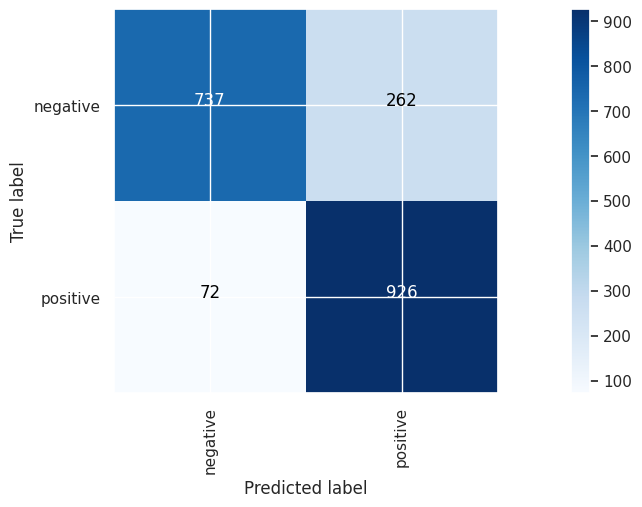

Final Accuracy
0.8327491236855283


In [42]:
# VSM models
results = []
name = "ConvResidualConnections"
description =   """
                number_of_filters=[32,64,128],
                kernel_size=4,
                dense_neurons=0,
                dropout=0.25, 
                pooling_size=4
                """
description = description.replace('\t', '').replace('\n', '').replace(' ', '')

number_of_filters=[32,64,128]
kernel_size=4
dense_neurons=0
dropout=0.25
pooling_size=4

# VSM models
results = []
for rep in vsm_model:
    build_exp03(name,
                description, 
                rep, 
                input_shape=(5000,1,),
                number_of_filters=number_of_filters,
                kernel_size=kernel_size,
                dense_neurons=dense_neurons,
                dropout=dropout, 
                pooling_size=pooling_size
                )

# Embedding with padding
embedding = layers.Embedding(input_dim=vocab_size,
                     output_dim=emb_dim,
                     trainable=True,
                     input_length=embedding_padding["train_text_features"].shape[1])
build_exp03(name,
            description, 
            embedding_padding, 
            input_shape=(embedding_padding["train_text_features"].shape[1],),
            embedding=embedding,
            number_of_filters=number_of_filters,
            kernel_size=kernel_size,
            dense_neurons=dense_neurons,
            dropout=dropout, 
            pooling_size=pooling_size        
            )

# GloVe
embedding = layers.Embedding(num_words,
                     emb_dim,
                     embeddings_initializer=Constant(embedding_glove["embedding_matrix"]),
                     trainable=True,
                     input_length=embedding_glove["train_text_features"].shape[1])

build_exp03(name,
            description, 
            embedding_glove, 
            input_shape=(embedding_glove["train_text_features"].shape[1],),
            embedding=embedding,
            number_of_filters=number_of_filters,
            kernel_size=kernel_size,
            dense_neurons=dense_neurons,
            dropout=dropout, 
            pooling_size=pooling_size        
            )
partial = pd.DataFrame(results)
partial.to_csv("exp_03_9.csv", index=False)

## Conclusiones

In [43]:
join_csv_for_experiment("03", 9)
pd.read_csv("exp_03.csv").sort_values(by=["accuracy"], ascending=False, ignore_index=True)[["classifier", "rep.model", "accuracy"]]

classifier  \
0        Exp03ConvResidualConnections number_of_filters=[32,64,128],kernel_size=4,dense_neurons=0,dropout=0.0,pooling_size=4   
1       Exp03ConvResidualConnections number_of_filters=[32,64,128],kernel_size=4,dense_neurons=64,dropout=0.0,pooling_size=4   
2      Exp03ConvResidualConnections number_of_filters=[64,128,256],kernel_size=4,dense_neurons=0,dropout=0.25,pooling_size=4   
3   Exp03ConvResidualConnections number_of_filters=[64,128,256],kernel_size=4,dense_neurons=128,dropout=False,pooling_size=4   
4   Exp03ConvResidualConnections number_of_filters=[64,128,256],kernel_size=4,dense_neurons=128,dropout=False,pooling_size=4   
5      Exp03ConvResidualConnections number_of_filters=[64,128,256],kernel_size=4,dense_neurons=0,dropout=0.15,pooling_size=4   
6      Exp03ConvResidualConnections number_of_filters=[64,128,256],kernel_size=4,dense_neurons=0,dropout=0.25,pooling_size=4   
7       Exp03ConvResidualConnections number_of_filters=[32,64,128],kernel_size=4,dense_neurons=0,dropout=0.15,pooling_size=4   
8       Exp03ConvResidualConnections number_of_filters=[32,64,128],kernel_size=4,dense_neurons=64,dropout=0.0,pooling_size=4   
9       Exp03ConvResidualConnections number_of_filters=[32,64,128],kernel_size=4,dense_neurons=0,dropout=0.25,pooling_size=4   
10     Exp03ConvResidualConnections number_of_filters=[64,128,256],kernel_size=4,dense_neurons=0,dropout=0.15,pooling_size=4   
11       Exp03ConvResidualConnections number_of_filters=[32,64,128],kernel_size=4,dense_neurons=0,dropout=0.0,pooling_size=4   
12       Exp03ConvResidualConnections number_of_filters=[32,64,128],kernel_size=4,dense_neurons=0,dropout=0.0,pooling_size=4   
13     Exp03ConvResidualConnections number_of_filters=[32,64,128],kernel_size=4,dense_neurons=128,dropout=0.0,pooling_size=4   
14     Exp03ConvResidualConnections number_of_filters=[64,128,256],kernel_size=4,dense_neurons=0,dropout=0.25,pooling_size=4   
15      Exp03ConvResidualConnections number_of_filters=[32,64,128],kernel_size=4,dense_neurons=0,dropout=0.25,pooling_size=4   
16     Exp03ConvResidualConnections number_of_filters=[64,128,256],kernel_size=4,dense_neurons=0,dropout=0.15,pooling_size=4   
17  Exp03ConvResidualConnections number_of_filters=[64,128,256],kernel_size=4,dense_neurons=128,dropout=False,pooling_size=4   
18     Exp03ConvResidualConnections number_of_filters=[32,64,128],kernel_size=4,dense_neurons=128,dropout=0.0,pooling_size=4   
19      Exp03ConvResidualConnections number_of_filters=[64,128,256],kernel_size=4,dense_neurons=0,dropout=0.0,pooling_size=4   
20      Exp03ConvResidualConnections number_of_filters=[32,64,128],kernel_size=4,dense_neurons=0,dropout=0.15,pooling_size=4   
21      Exp03ConvResidualConnections number_of_filters=[32,64,128],kernel_size=4,dense_neurons=64,dropout=0.0,pooling_size=4   
22     Exp03ConvResidualConnections number_of_filters=[64,128,256],kernel_size=4,dense_neurons=0,dropout=0.25,pooling_size=4   
23      Exp03ConvResidualConnections number_of_filters=[64,128,256],kernel_size=4,dense_neurons=0,dropout=0.0,pooling_size=4   
24      Exp03ConvResidualConnections number_of_filters=[32,64,128],kernel_size=4,dense_neurons=0,dropout=0.15,pooling_size=4   
25  Exp03ConvResidualConnections number_of_filters=[64,128,256],kernel_size=4,dense_neurons=128,dropout=False,pooling_size=4   
26  Exp03ConvResidualConnections number_of_filters=[64,128,256],kernel_size=4,dense_neurons=128,dropout=False,pooling_size=4   
27     Exp03ConvResidualConnections number_of_filters=[32,64,128],kernel_size=4,dense_neurons=128,dropout=0.0,pooling_size=4   
28      Exp03ConvResidualConnections number_of_filters=[64,128,256],kernel_size=4,dense_neurons=0,dropout=0.0,pooling_size=4   
29     Exp03ConvResidualConnections number_of_filters=[64,128,256],kernel_size=4,dense_neurons=0,dropout=0.15,pooling_size=4   
30      Exp03ConvResidualConnections number_of_filters=[32,64,128],kernel_size=4,dense_neurons=0,dropout=0.25,pooling_size=4   
31      Exp03ConvR